# Imports & Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder, RobustScaler
import scipy
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, chi2, SelectKBest
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

# Helper Functions

In [89]:
# Single feature partial dependence plot
def pdp(feature_of_interest, test_data, model, title='', ylabel='', xlabel='', xlim=(0, 1)):
    # define parameters for the plot
    isolated = pdp_isolate(
        model = model,
        dataset = test_data,
        model_features = test_data.columns,
        feature = feature_of_interest,
        num_grid_points =  300
    )
    
    # plot isolated features
    pdp_plot(isolated, feature_name=feature_of_interest)
    plt.xlim(xlim)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

In [3]:
# Distribution plot
def distribution_plot(data):
    sns.displot(data, kind='hist', kde=True)
    plt.ylabel('Frequency')
    plt.title(f'{data.name} distribution')

In [4]:
# Functions for box plots 
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

def fillMissingCatColumns(data,categorical):
    for c in categorical:
        data[c] = data[c].astype('category')
        if data[c].isnull().any():
            data[c] = data[c].cat.add_categories(['MISSING'])
            data[c] = data[c].fillna('MISSING')
    
def getboxPlots(data,var,categorical):
    fillMissingCatColumns(data,categorical)
    f = pd.melt(data, id_vars=var, value_vars=categorical)
    g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, height=5)
    g = g.map(boxplot, "value", var)

In [5]:
# Correlation Heatmap
def getCorrHeatMap(dataFrame,figSize=[12,9]):
    corrmat = dataFrame.corr()
    f, ax = plt.subplots(figsize=(figSize[0], figSize[1]))
    sns.heatmap(corrmat, vmax=.8, square=True);
    


def getZoomedCorrHeatMap(dataFrame,featureCount,target,figSize=[12,9]):
    corrmat = dataFrame.corr()
    cols = corrmat.nlargest(featureCount, target)[target].index
    f , ax = plt.subplots(figsize = (figSize[0],figSize[1]))
    cm = np.corrcoef(dataFrame[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

In [6]:
# Mahalanobis function outlier detection
def mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = scipy.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

In [7]:
# PCA plot function
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

# Loading Data 

In [8]:
data = pd.read_csv('StudentRecordsConcealed.csv', delimiter=',')


In [9]:
data.head()

school id school type  alevel math  olevel math  chem   phy   bio  english  \
0      EIBS          IG          0.0         65.0  35.0  35.0  35.0     65.0   
1      DAIS    American         95.0         99.0  96.0  93.0   0.0     98.0   
2      EBIS          IG         45.0         75.0  65.0  75.0  35.0     65.0   
3       CIS          IG         75.0         65.0  75.0  75.0  75.0     75.0   
4       BKS    American         87.0         87.0   0.0  94.0   0.0     90.0   

   ap course  cs ig  adv math  international student  transferred courses  \
0        0.0    0.0       0.0                    0.0                  0.0   
1        0.0    0.0       1.0                    0.0                  0.0   
2        0.0    0.0       1.0                    0.0                  0.0   
3        0.0    0.0       1.0                    0.0                  0.0   
4        0.0    0.0       1.0                    0.0                  0.0   

  major specialization  cgpa  credit hours completed  
0   BUS            BUS  1.71                    57.0  
1   ENG            SDE  1.69                    68.0  
2   BUS            BUS  2.20                    87.0  
3   BUS            BUS  1.76                    54.0  
4   BUS            BUS  2.00                    53.0

In [10]:
data.columns


Index(['school id', 'school type', 'alevel math', 'olevel math', 'chem', 'phy',
       'bio', 'english', 'ap course', 'cs ig', 'adv math',
       'international student', 'transferred courses', 'major',
       'specialization', 'cgpa', 'credit hours completed'],
      dtype='object')

Removing White Space & Set Categorical Features to Lowercase

In [11]:
data['school id'] = data['school id'].str.replace(" ", "")
data['school id'] = data['school id'].str.lower()

data['school type'] = data['school type'].str.replace(" ", "")
data['school type'] = data['school type'].str.lower()

data['major'] = data['major'].str.replace(" ", "")
data['major'] = data['major'].str.lower()

data['specialization'] = data['specialization'].str.replace(" ", "")
data['specialization'] = data['specialization'].str.lower()

In [12]:
data.head()

school id school type  alevel math  olevel math  chem   phy   bio  english  \
0      eibs          ig          0.0         65.0  35.0  35.0  35.0     65.0   
1      dais    american         95.0         99.0  96.0  93.0   0.0     98.0   
2      ebis          ig         45.0         75.0  65.0  75.0  35.0     65.0   
3       cis          ig         75.0         65.0  75.0  75.0  75.0     75.0   
4       bks    american         87.0         87.0   0.0  94.0   0.0     90.0   

   ap course  cs ig  adv math  international student  transferred courses  \
0        0.0    0.0       0.0                    0.0                  0.0   
1        0.0    0.0       1.0                    0.0                  0.0   
2        0.0    0.0       1.0                    0.0                  0.0   
3        0.0    0.0       1.0                    0.0                  0.0   
4        0.0    0.0       1.0                    0.0                  0.0   

  major specialization  cgpa  credit hours completed  
0   bus            bus  1.71                    57.0  
1   eng            sde  1.69                    68.0  
2   bus            bus  2.20                    87.0  
3   bus            bus  1.76                    54.0  
4   bus            bus  2.00                    53.0

# Data Exploration

## Univariate Exploration

Numerical Variables

In [13]:
numerical_features = ['alevel math', 'olevel math', 'chem', 'phy', 'bio', 'english', 
                      'transferred courses', 'cgpa', 'credit hours completed']

data.describe().transpose()

count       mean        std    min     25%    50%  \
alevel math             297.0  28.111111  40.006812   0.00   0.000   0.00   
olevel math             299.0  75.391304  22.076987   0.00  70.000  78.00   
chem                    298.0  66.563758  30.631446   0.00  65.000  75.00   
phy                     297.0  58.565657  35.788841   0.00  45.000  74.00   
bio                     297.0  54.070707  37.490337   0.00   0.000  69.00   
english                 299.0  80.812709  14.156545   0.00  70.000  84.00   
ap course               298.0   0.013423   0.115270   0.00   0.000   0.00   
cs ig                   298.0   0.130872   0.337828   0.00   0.000   0.00   
adv math                298.0   0.338926   0.474141   0.00   0.000   0.00   
international student   299.0   0.090301   0.287093   0.00   0.000   0.00   
transferred courses     299.0   0.267559   1.422017   0.00   0.000   0.00   
cgpa                    299.0   2.711940   0.798185   0.84   2.015   2.65   
credit hours completed  299.0  64.568562  24.141595  30.00  45.000  63.00   

                          75%    max  
alevel math             75.00  100.0  
olevel math             88.00  100.0  
chem                    86.75  100.0  
phy                     85.00  100.0  
bio                     85.00  100.0  
english                 93.00  100.0  
ap course                0.00    1.0  
cs ig                    0.00    1.0  
adv math                 1.00    1.0  
international student    0.00    1.0  
transferred courses      0.00   13.0  
cgpa                     3.33    4.3  
credit hours completed  81.00  126.0

Distributions, Skewness & Kurtosis 

Skewness: 0.805723
Kurtosis: -1.220720


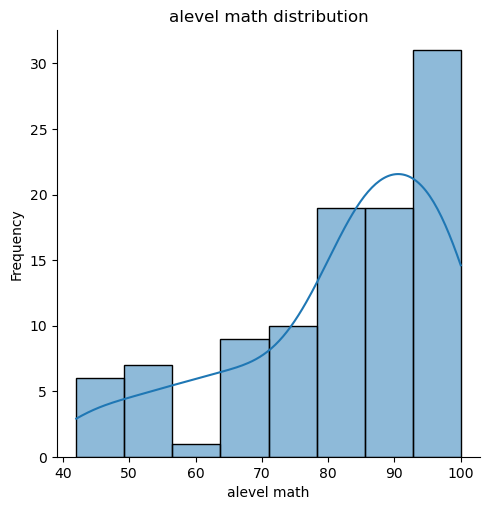

In [14]:
zero_val = data[data['alevel math'] != 0]
zero_val['alevel math']
distribution_plot(zero_val['alevel math'])
print("Skewness: %f" % data['alevel math'].skew())
print("Kurtosis: %f" % data['alevel math'].kurt())

Skewness: -2.146703
Kurtosis: 5.181387


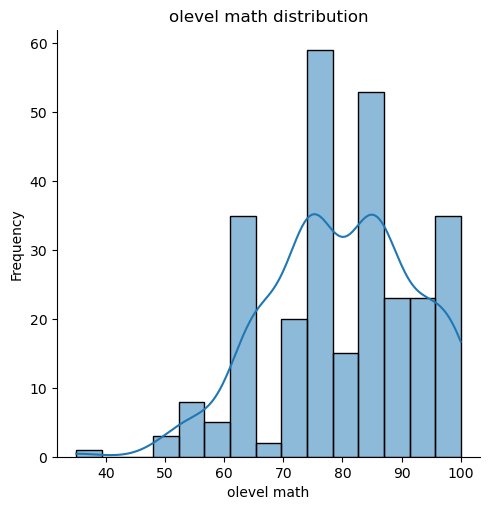

In [15]:
zero_val = data[data['olevel math'] != 0]
zero_val['olevel math']
distribution_plot(zero_val['olevel math'])
print("Skewness: %f" % data['olevel math'].skew())
print("Kurtosis: %f" % data['olevel math'].kurt())

Skewness: -1.279146
Kurtosis: 0.505833


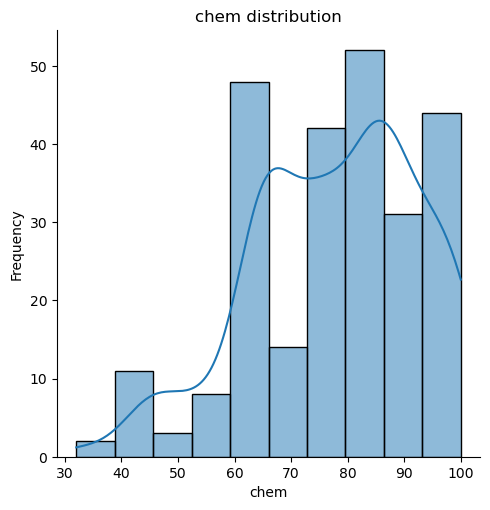

In [16]:
zero_val = data[data['chem'] != 0]
zero_val['chem']
distribution_plot(zero_val['chem'])
print("Skewness: %f" % data['chem'].skew())
print("Kurtosis: %f" % data['chem'].kurt())

Skewness: -0.764402
Kurtosis: -0.941373


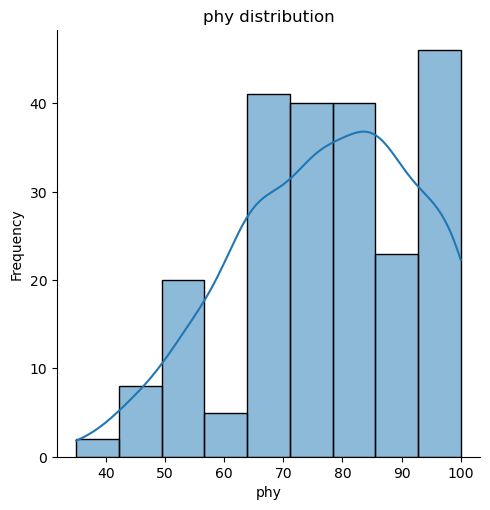

In [17]:
zero_val = data[data['phy'] != 0]
zero_val['phy']
distribution_plot(zero_val['phy'])
print("Skewness: %f" % data['phy'].skew())
print("Kurtosis: %f" % data['phy'].kurt())

Skewness: -0.545380
Kurtosis: -1.358490


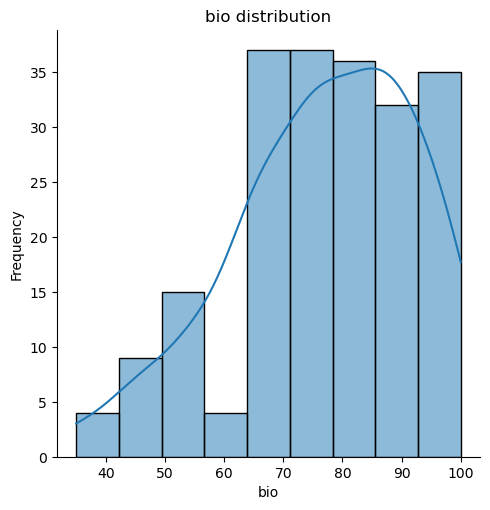

In [18]:
zero_val = data[data['bio'] != 0]
zero_val['bio']
distribution_plot(zero_val['bio'])
print("Skewness: %f" % data['bio'].skew())
print("Kurtosis: %f" % data['bio'].kurt())

Skewness: -0.872001
Kurtosis: 2.438658


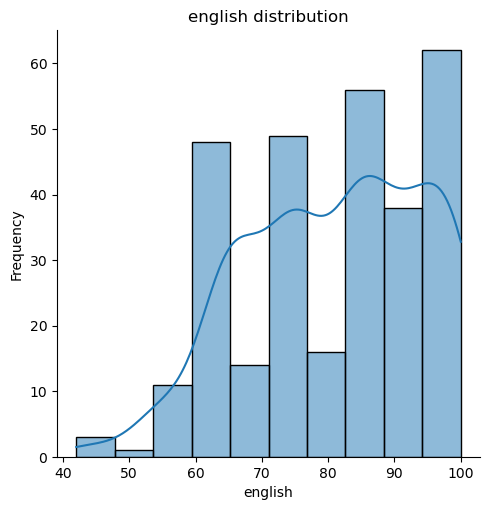

In [19]:
zero_val = data[data['english'] != 0]
zero_val['english']
distribution_plot(zero_val['english'])
print("Skewness: %f" % data['english'].skew())
print("Kurtosis: %f" % data['english'].kurt())

Skewness: 7.061565
Kurtosis: 54.950376


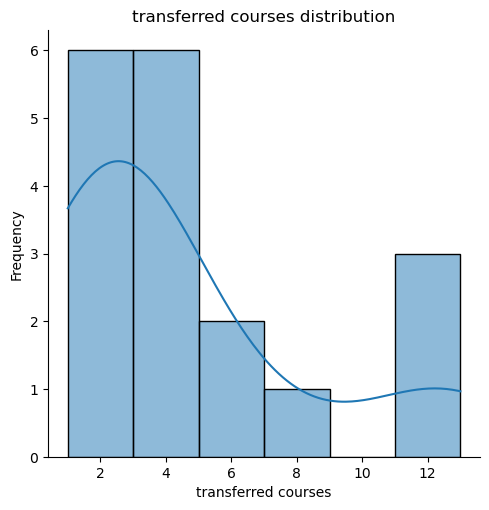

In [20]:
zero_val = data[data['transferred courses'] != 0]
zero_val['transferred courses']
distribution_plot(zero_val['transferred courses'])
print("Skewness: %f" % data['transferred courses'].skew())
print("Kurtosis: %f" % data['transferred courses'].kurt())

Skewness: 0.148447
Kurtosis: -0.965700


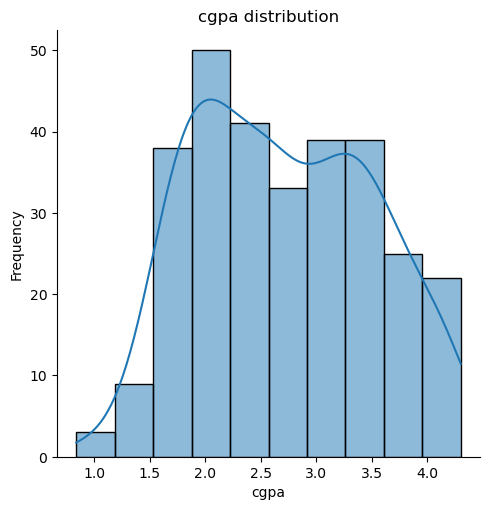

In [21]:
zero_val = data[data['cgpa'] != 0]
zero_val['cgpa']
distribution_plot(zero_val['cgpa'])
print("Skewness: %f" % data['cgpa'].skew())
print("Kurtosis: %f" % data['cgpa'].kurt())

Skewness: 0.374649
Kurtosis: -0.934295


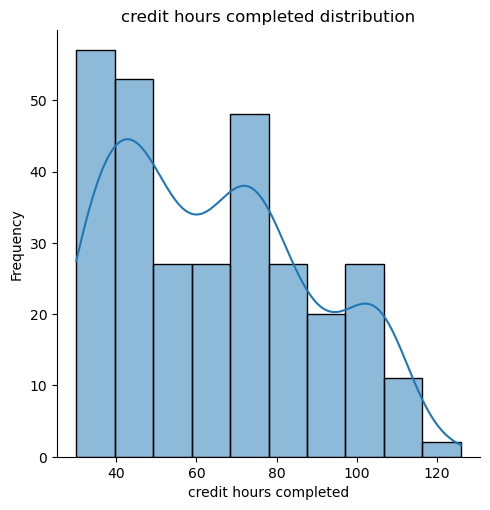

In [22]:
zero_val = data[data['credit hours completed'] != 0]
zero_val['credit hours completed']
distribution_plot(zero_val['credit hours completed'])
print("Skewness: %f" % data['credit hours completed'].skew())
print("Kurtosis: %f" % data['credit hours completed'].kurt())

Categorical Variables

In [23]:
school_id = data['school id'].astype('category')
school_id.describe()

count      300
unique     138
top       ebis
freq        19
Name: school id, dtype: object

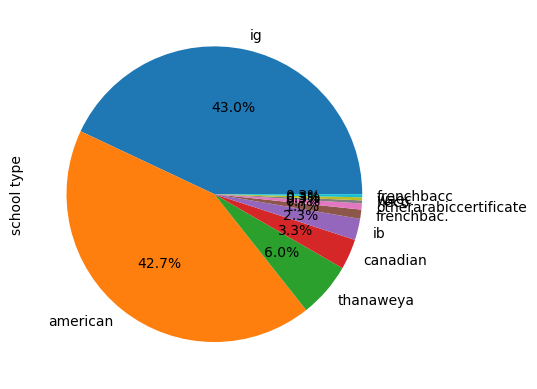

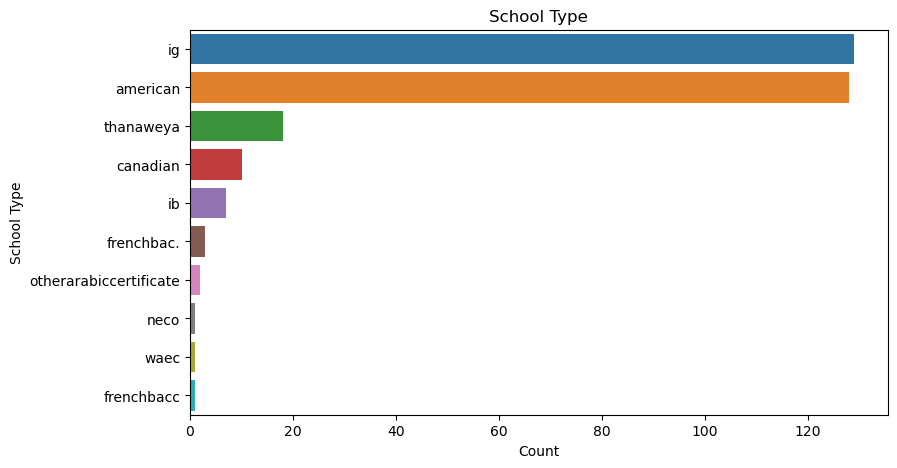

In [24]:
# pie plot
data['school type'].value_counts().plot(kind='pie', autopct='%1.1f%%')

# bar chart
order = data['school type'].value_counts().index
plt.figure(figsize=(9, 5))
sns.countplot(data=data, y='school type', order=order)
plt.title('School Type')
plt.xlabel('Count')
plt.ylabel('School Type');

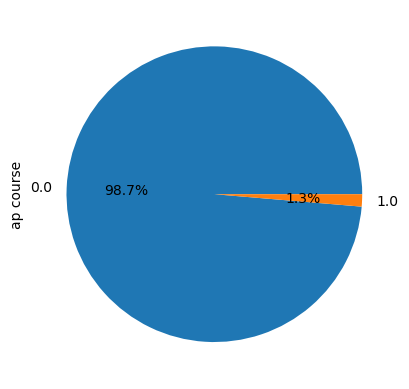

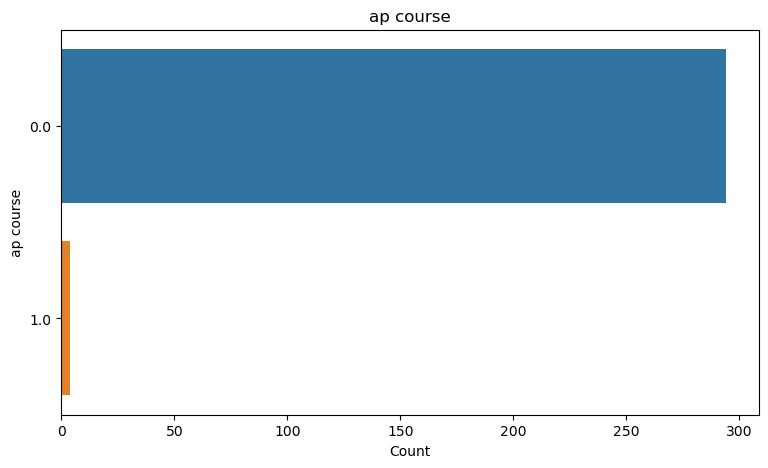

In [25]:
# pie plot
data['ap course'].value_counts().plot(kind='pie', autopct='%1.1f%%')

# bar chart
order = data['ap course'].value_counts().index
plt.figure(figsize=(9, 5))
sns.countplot(data=data, y='ap course', order=order)
plt.title('ap course')
plt.xlabel('Count')
plt.ylabel('ap course');

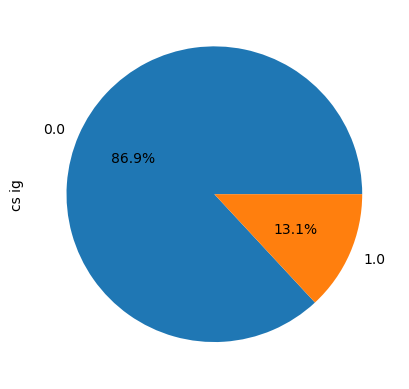

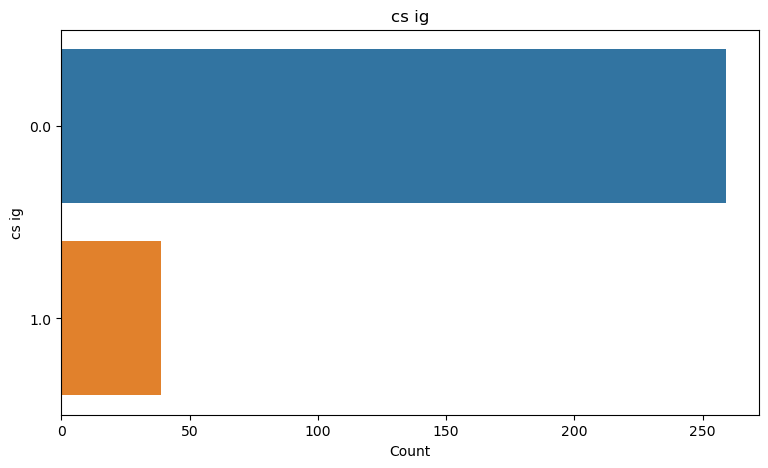

In [26]:
# pie plot
data['cs ig'].value_counts().plot(kind='pie', autopct='%1.1f%%')

# bar chart
order = data['cs ig'].value_counts().index
plt.figure(figsize=(9, 5))
sns.countplot(data=data, y='cs ig', order=order)
plt.title('cs ig')
plt.xlabel('Count')
plt.ylabel('cs ig');

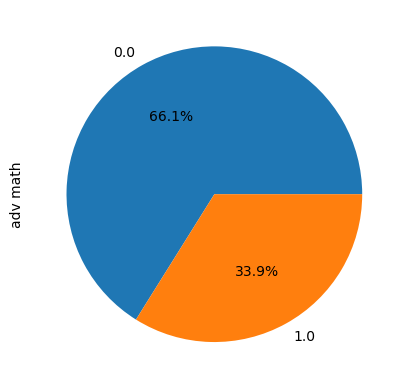

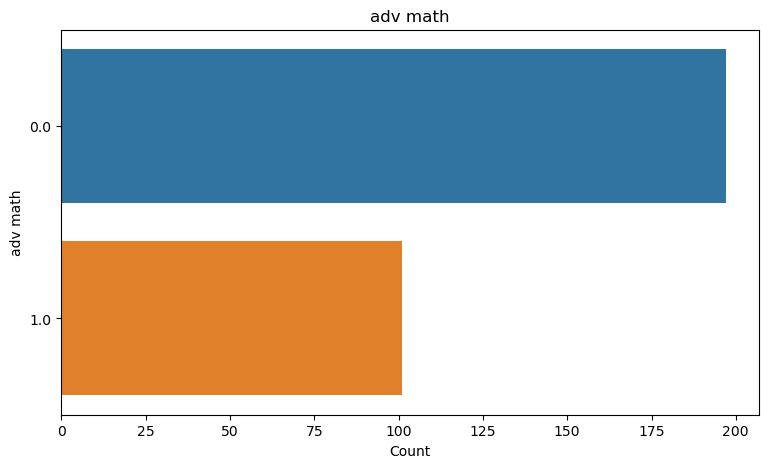

In [27]:
# pie plot
data['adv math'].value_counts().plot(kind='pie', autopct='%1.1f%%')

# bar chart
order = data['adv math'].value_counts().index
plt.figure(figsize=(9, 5))
sns.countplot(data=data, y='adv math', order=order)
plt.title('adv math')
plt.xlabel('Count')
plt.ylabel('adv math');

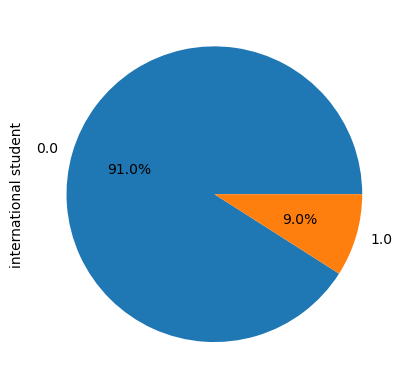

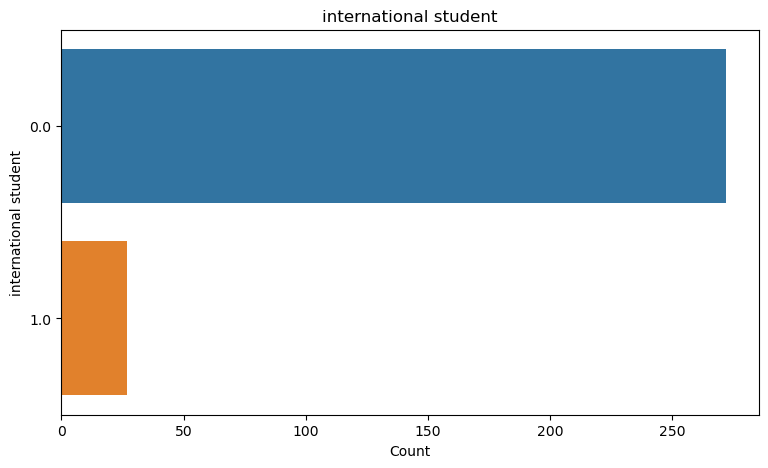

In [28]:
# pie plot
data['international student'].value_counts().plot(kind='pie', autopct='%1.1f%%')

# bar chart
order = data['international student'].value_counts().index
plt.figure(figsize=(9, 5))
sns.countplot(data=data, y='international student', order=order)
plt.title('international student')
plt.xlabel('Count')
plt.ylabel('international student');

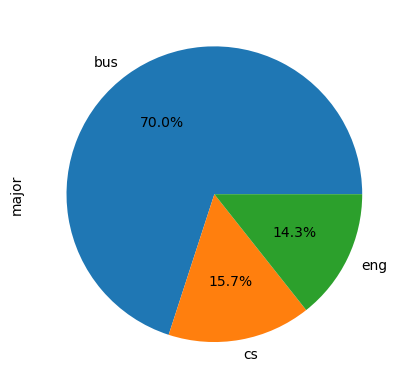

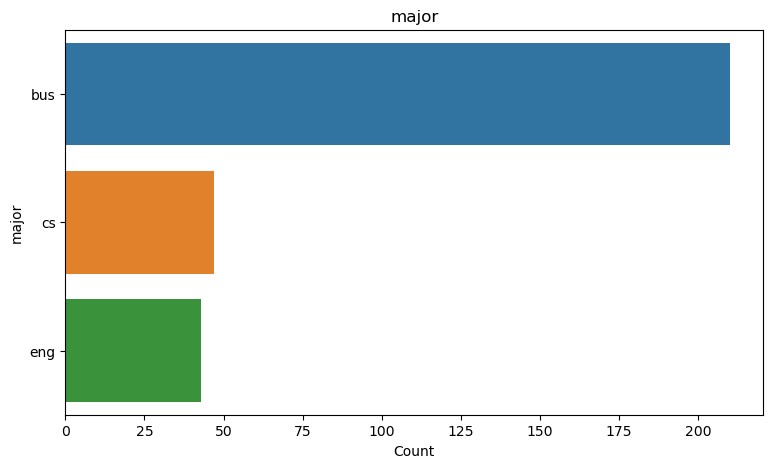

In [29]:
# pie plot
data['major'].value_counts().plot(kind='pie', autopct='%1.1f%%')

# bar chart
order = data['major'].value_counts().index
plt.figure(figsize=(9, 5))
sns.countplot(data=data, y='major', order=order)
plt.title('major')
plt.xlabel('Count')
plt.ylabel('major');

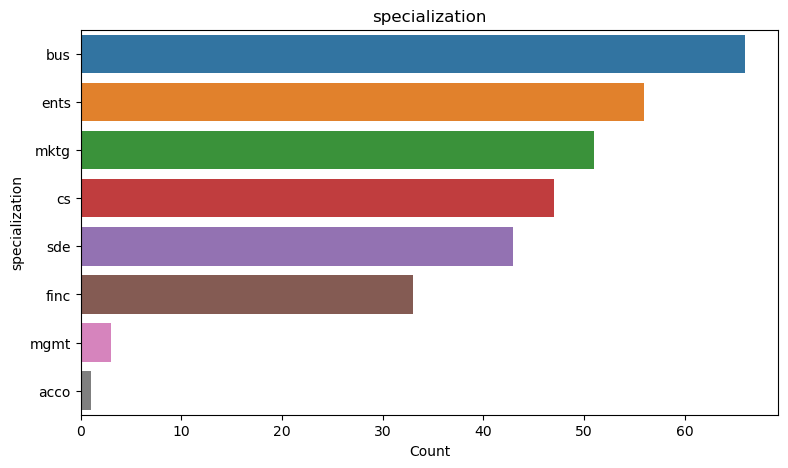

In [30]:
# pie plot
# data['specialization'].value_counts().plot(kind='pie', autopct='%1.1f%%')

# bar chart
order = data['specialization'].value_counts().index
plt.figure(figsize=(9, 5))
sns.countplot(data=data, y='specialization', order=order)
plt.title('specialization')
plt.xlabel('Count')
plt.ylabel('specialization');

<Axes: xlabel='specialization'>

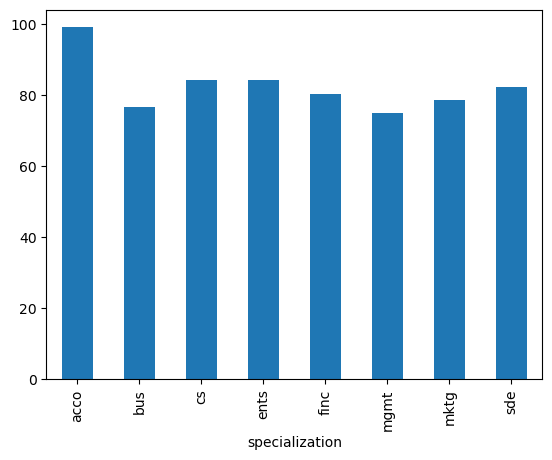

In [31]:
df_groups = data.groupby(['specialization'])['english'].mean()
#create bar plot by group
df_groups.plot(kind='bar')

## Bivariate Exploration

Numerical-Numerical

In [32]:
zero_val = data[data['alevel math'] != 0]

<Axes: xlabel='alevel math', ylabel='cgpa'>

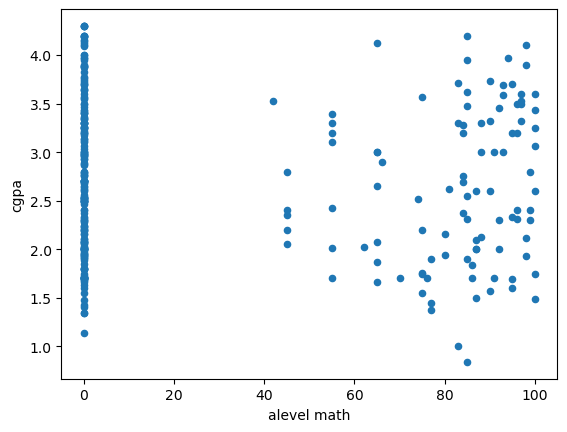

In [33]:
data.plot.scatter(x='alevel math', y='cgpa')

<Axes: xlabel='olevel math', ylabel='cgpa'>

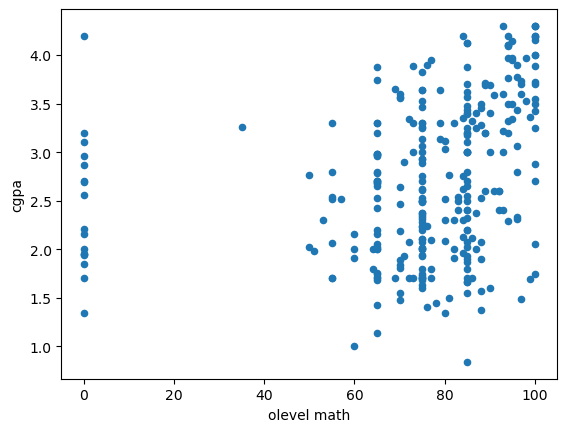

In [34]:
data.plot.scatter(x='olevel math', y='cgpa')

array([[<Axes: xlabel='alevel math', ylabel='alevel math'>,
        <Axes: xlabel='olevel math', ylabel='alevel math'>,
        <Axes: xlabel='chem', ylabel='alevel math'>,
        <Axes: xlabel='phy', ylabel='alevel math'>,
        <Axes: xlabel='bio', ylabel='alevel math'>,
        <Axes: xlabel='english', ylabel='alevel math'>,
        <Axes: xlabel='ap course', ylabel='alevel math'>,
        <Axes: xlabel='cs ig', ylabel='alevel math'>,
        <Axes: xlabel='adv math', ylabel='alevel math'>,
        <Axes: xlabel='international student', ylabel='alevel math'>,
        <Axes: xlabel='transferred courses', ylabel='alevel math'>,
        <Axes: xlabel='cgpa', ylabel='alevel math'>,
        <Axes: xlabel='credit hours completed', ylabel='alevel math'>],
       [<Axes: xlabel='alevel math', ylabel='olevel math'>,
        <Axes: xlabel='olevel math', ylabel='olevel math'>,
        <Axes: xlabel='chem', ylabel='olevel math'>,
        <Axes: xlabel='phy', ylabel='olevel math'>,
        <A

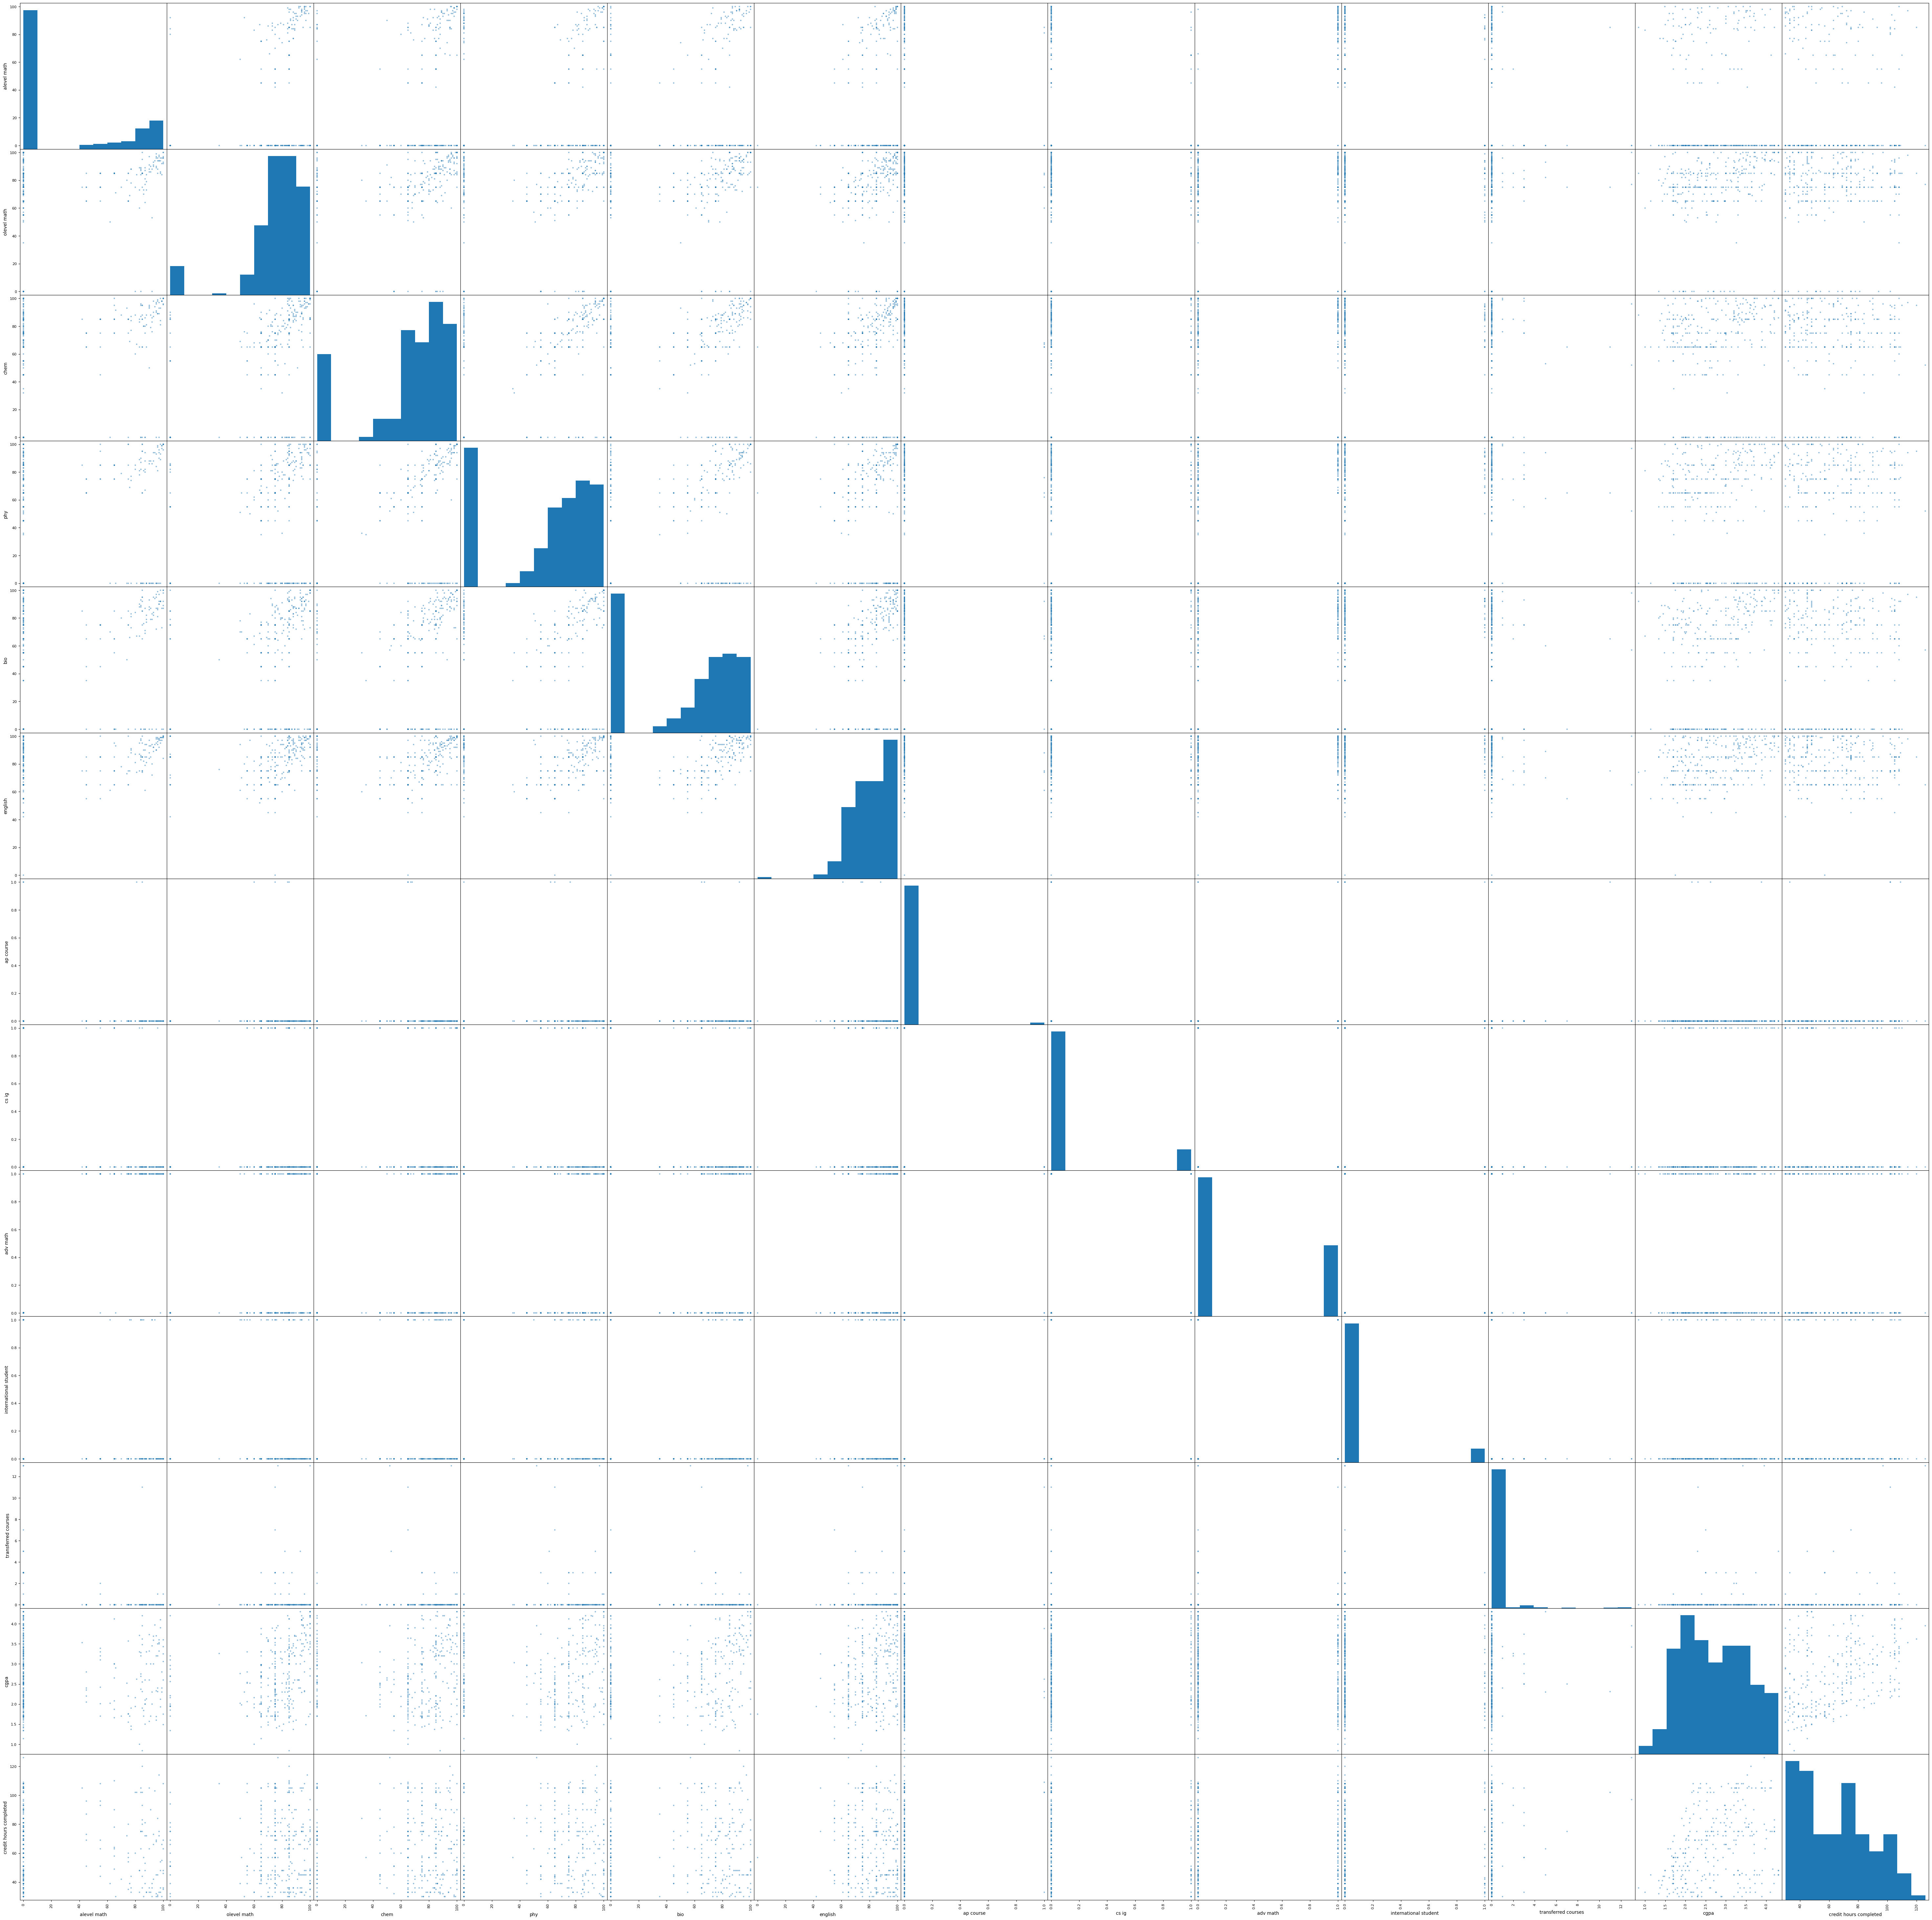

In [35]:
pd.plotting.scatter_matrix(data, figsize=(75,75), grid=True)

Numerical-Categorical

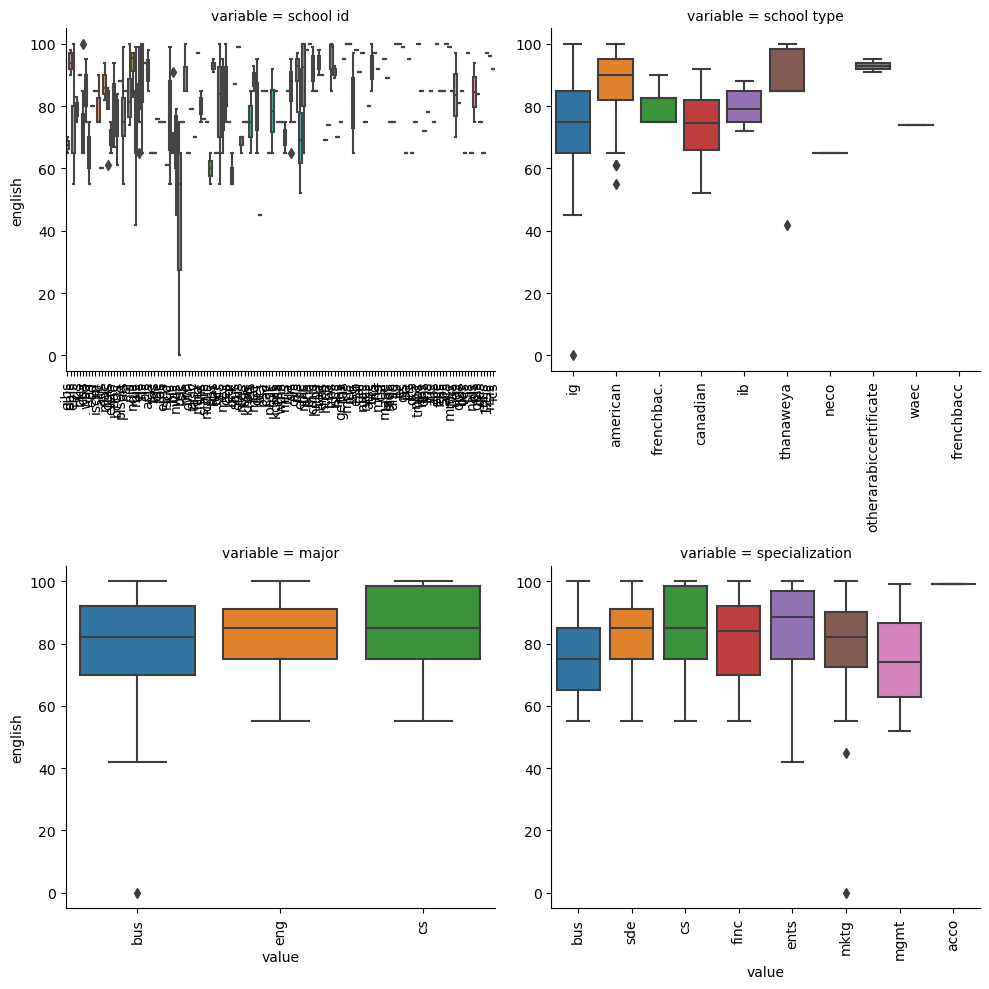

In [36]:
data_copy = data.copy()
categorical_features = [f for f in data_copy.columns if data_copy.dtypes[f] == 'object']
getboxPlots(data_copy, 'english', categorical_features)

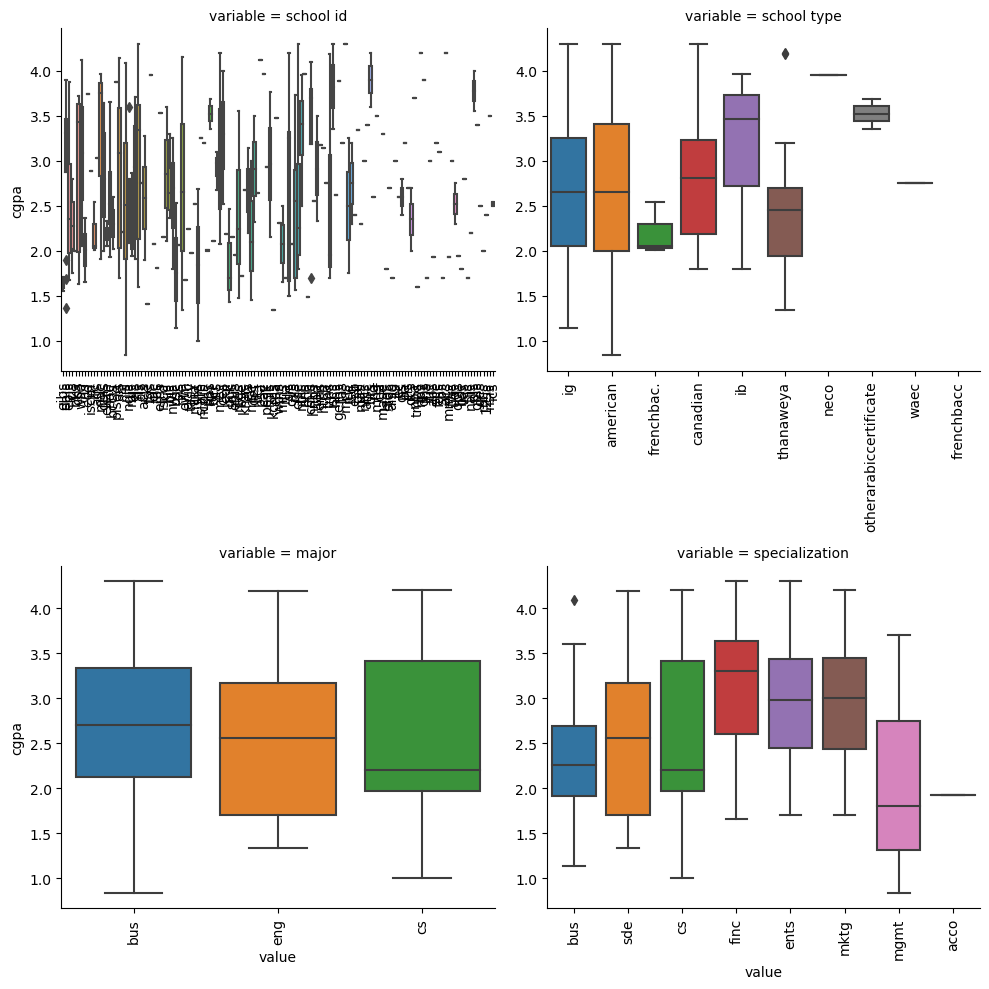

In [37]:
getboxPlots(data_copy, 'cgpa', categorical_features)

Categorical-Categorical

In [38]:
# School type and specialization
compare = pd.crosstab(data['school type'], data['specialization'])

print(compare)

chi2, p, dof, ex = stats.chi2_contingency(compare)

print(f'Chi_square value {chi2}\n\np value {p}\n\ndegrees of freedom {dof}\n\n expected {ex}')

specialization          acco  bus  cs  ents  finc  mgmt  mktg  sde
school type                                                       
american                   1   25  16    35    13     2    21   15
canadian                   0    2   1     1     2     1     2    1
frenchbac.                 0    1   2     0     0     0     0    0
frenchbacc                 0    0   1     0     0     0     0    0
ib                         0    0   0     1     1     0     5    0
ig                         0   36  21    16    15     0    20   21
neco                       0    0   0     0     0     0     0    1
otherarabiccertificate     0    0   0     0     1     0     1    0
thanaweya                  0    2   5     3     1     0     2    5
waec                       0    0   1     0     0     0     0    0
Chi_square value 76.35971670672092

p value 0.12028047708313964

degrees of freedom 63

 expected [[4.26666667e-01 2.81600000e+01 2.00533333e+01 2.38933333e+01
  1.40800000e+01 1.28000000e+00 2.17

# Data Preprocessing

In [39]:
data

school id school type  alevel math  olevel math   chem   phy    bio  \
0        eibs          ig          0.0         65.0   35.0  35.0   35.0   
1        dais    american         95.0         99.0   96.0  93.0    0.0   
2        ebis          ig         45.0         75.0   65.0  75.0   35.0   
3         cis          ig         75.0         65.0   75.0  75.0   75.0   
4         bks    american         87.0         87.0    0.0  94.0    0.0   
..        ...         ...          ...          ...    ...   ...    ...   
295       sfs          ig         55.0         85.0   85.0   NaN   65.0   
296       brs          ig          0.0        100.0   75.0   0.0   85.0   
297       ics    american          0.0         83.0    0.0   0.0    0.0   
298       ics    american          0.0         83.0    0.0   0.0    0.0   
299       ols    american          0.0        100.0  100.0   0.0  100.0   

     english  ap course  cs ig  adv math  international student  \
0       65.0        0.0    0.0       0.0                    0.0   
1       98.0        0.0    0.0       1.0                    0.0   
2       65.0        0.0    0.0       1.0                    0.0   
3       75.0        0.0    0.0       1.0                    0.0   
4       90.0        0.0    0.0       1.0                    0.0   
..       ...        ...    ...       ...                    ...   
295    100.0        0.0    1.0       1.0                    0.0   
296    100.0        0.0    0.0       0.0                    0.0   
297     92.0        0.0    1.0       0.0                    0.0   
298     92.0        0.0    0.0       0.0                    0.0   
299     94.0        0.0    0.0       0.0                    0.0   

     transferred courses major specialization  cgpa  credit hours completed  
0                    0.0   bus            bus  1.71                    57.0  
1                    0.0   eng            sde  1.69                    68.0  
2                    0.0   bus            bus  2.20                    87.0  
3                    0.0   bus            bus  1.76                    54.0  
4                    0.0   bus            bus  2.00                    53.0  
..                   ...   ...            ...   ...                     ...  
295                  0.0   eng            sde  3.10                    63.0  
296                  0.0   bus           ents  4.20                    75.0  
297                  0.0   bus            bus  2.50                    69.0  
298                  0.0   bus            bus  2.54                    69.0  
299                  0.0   bus           mktg  4.00                    76.0  

[300 rows x 17 columns]

In [40]:
data.insert(0,'specialization2','')
data['specialization2'] = data['specialization'] 

In [41]:
data.pop('specialization')

0       bus
1       sde
2       bus
3       bus
4       bus
       ... 
295     sde
296    ents
297     bus
298     bus
299    mktg
Name: specialization, Length: 300, dtype: object

In [42]:
data = data.rename(columns={'specialization2':'specialization'})

In [43]:
# Drop major & school id
data = data.drop('major', axis=1)
data = data.drop('school id', axis=1)
data = data.drop('adv math', axis=1)

In [44]:
data

specialization school type  alevel math  olevel math   chem   phy    bio  \
0              bus          ig          0.0         65.0   35.0  35.0   35.0   
1              sde    american         95.0         99.0   96.0  93.0    0.0   
2              bus          ig         45.0         75.0   65.0  75.0   35.0   
3              bus          ig         75.0         65.0   75.0  75.0   75.0   
4              bus    american         87.0         87.0    0.0  94.0    0.0   
..             ...         ...          ...          ...    ...   ...    ...   
295            sde          ig         55.0         85.0   85.0   NaN   65.0   
296           ents          ig          0.0        100.0   75.0   0.0   85.0   
297            bus    american          0.0         83.0    0.0   0.0    0.0   
298            bus    american          0.0         83.0    0.0   0.0    0.0   
299           mktg    american          0.0        100.0  100.0   0.0  100.0   

     english  ap course  cs ig  international student  transferred courses  \
0       65.0        0.0    0.0                    0.0                  0.0   
1       98.0        0.0    0.0                    0.0                  0.0   
2       65.0        0.0    0.0                    0.0                  0.0   
3       75.0        0.0    0.0                    0.0                  0.0   
4       90.0        0.0    0.0                    0.0                  0.0   
..       ...        ...    ...                    ...                  ...   
295    100.0        0.0    1.0                    0.0                  0.0   
296    100.0        0.0    0.0                    0.0                  0.0   
297     92.0        0.0    1.0                    0.0                  0.0   
298     92.0        0.0    0.0                    0.0                  0.0   
299     94.0        0.0    0.0                    0.0                  0.0   

     cgpa  credit hours completed  
0    1.71                    57.0  
1    1.69                    68.0  
2    2.20                    87.0  
3    1.76                    54.0  
4    2.00                    53.0  
..    ...                     ...  
295  3.10                    63.0  
296  4.20                    75.0  
297  2.50                    69.0  
298  2.54                    69.0  
299  4.00                    76.0  

[300 rows x 14 columns]

## Checking Missing Values

In [45]:
data.isnull().sum()


specialization            0
school type               0
alevel math               3
olevel math               1
chem                      2
phy                       3
bio                       3
english                   1
ap course                 2
cs ig                     2
international student     1
transferred courses       1
cgpa                      1
credit hours completed    1
dtype: int64

In [46]:
# Replace with median of group specialization
data['alevel math'].fillna(data.groupby('specialization')['alevel math'].transform('median'), inplace=True)
data['olevel math'].fillna(data.groupby('specialization')['olevel math'].transform('median'), inplace=True)
data['chem'].fillna(data.groupby('specialization')['chem'].transform('median'), inplace=True)
data['phy'].fillna(data.groupby('specialization')['phy'].transform('median'), inplace=True)
data['bio'].fillna(data.groupby('specialization')['bio'].transform('median'), inplace=True)
data['english'].fillna(data.groupby('specialization')['english'].transform('median'), inplace=True)
data['ap course'].fillna(data.groupby('specialization')['ap course'].transform('median'), inplace=True)
data['cs ig'].fillna(data.groupby('specialization')['cs ig'].transform('median'), inplace=True)
data['international student'].fillna(data.groupby('specialization')['international student'].transform('median'), inplace=True)
data['transferred courses'].fillna(data.groupby('specialization')['transferred courses'].transform('median'), inplace=True)
data['cgpa'].fillna(data.groupby('specialization')['cgpa'].transform('median'), inplace=True)
data['credit hours completed'].fillna(data.groupby('specialization')['credit hours completed'].transform('median'), inplace=True)

In [47]:
data

specialization school type  alevel math  olevel math   chem   phy    bio  \
0              bus          ig          0.0         65.0   35.0  35.0   35.0   
1              sde    american         95.0         99.0   96.0  93.0    0.0   
2              bus          ig         45.0         75.0   65.0  75.0   35.0   
3              bus          ig         75.0         65.0   75.0  75.0   75.0   
4              bus    american         87.0         87.0    0.0  94.0    0.0   
..             ...         ...          ...          ...    ...   ...    ...   
295            sde          ig         55.0         85.0   85.0  85.0   65.0   
296           ents          ig          0.0        100.0   75.0   0.0   85.0   
297            bus    american          0.0         83.0    0.0   0.0    0.0   
298            bus    american          0.0         83.0    0.0   0.0    0.0   
299           mktg    american          0.0        100.0  100.0   0.0  100.0   

     english  ap course  cs ig  international student  transferred courses  \
0       65.0        0.0    0.0                    0.0                  0.0   
1       98.0        0.0    0.0                    0.0                  0.0   
2       65.0        0.0    0.0                    0.0                  0.0   
3       75.0        0.0    0.0                    0.0                  0.0   
4       90.0        0.0    0.0                    0.0                  0.0   
..       ...        ...    ...                    ...                  ...   
295    100.0        0.0    1.0                    0.0                  0.0   
296    100.0        0.0    0.0                    0.0                  0.0   
297     92.0        0.0    1.0                    0.0                  0.0   
298     92.0        0.0    0.0                    0.0                  0.0   
299     94.0        0.0    0.0                    0.0                  0.0   

     cgpa  credit hours completed  
0    1.71                    57.0  
1    1.69                    68.0  
2    2.20                    87.0  
3    1.76                    54.0  
4    2.00                    53.0  
..    ...                     ...  
295  3.10                    63.0  
296  4.20                    75.0  
297  2.50                    69.0  
298  2.54                    69.0  
299  4.00                    76.0  

[300 rows x 14 columns]

## Feature Encoding 

In [48]:
# Label Encoder
le = LabelEncoder()
data['specialization'] = le.fit_transform(data['specialization'])
data['school type'] = le.fit_transform(data['school type'])


## Outlier Detection

Mahalanobis Distance - Multivariate Outlier Detection

In [49]:
df = data[['specialization','alevel math', 'olevel math', 'chem', 'phy', 'bio', 
                                                     'english', 'ap course', 'cs ig', 
                                                     'international student', 'transferred courses', 'cgpa',
                                                     'credit hours completed', 'school type']]

df['mahalanobis'] = mahalanobis(x=df, data=data[['specialization','alevel math', 'olevel math', 'chem', 'phy', 'bio', 
                                                     'english', 'ap course', 'cs ig', 
                                                     'international student', 'transferred courses', 'cgpa',
                                                     'credit hours completed', 'school type']])

C:\Users\Islam.Anwar\AppData\Local\Temp\ipykernel_9860\3554728767.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mahalanobis'] = mahalanobis(x=df, data=data[['specialization','alevel math', 'olevel math', 'chem', 'phy', 'bio',


In [50]:
df.head()

specialization  alevel math  olevel math  chem   phy   bio  english  \
0               1          0.0         65.0  35.0  35.0  35.0     65.0   
1               7         95.0         99.0  96.0  93.0   0.0     98.0   
2               1         45.0         75.0  65.0  75.0  35.0     65.0   
3               1         75.0         65.0  75.0  75.0  75.0     75.0   
4               1         87.0         87.0   0.0  94.0   0.0     90.0   

   ap course  cs ig  international student  transferred courses  cgpa  \
0        0.0    0.0                    0.0                  0.0  1.71   
1        0.0    0.0                    0.0                  0.0  1.69   
2        0.0    0.0                    0.0                  0.0  2.20   
3        0.0    0.0                    0.0                  0.0  1.76   
4        0.0    0.0                    0.0                  0.0  2.00   

   credit hours completed  school type  mahalanobis  
0                    57.0            5     4.765611  
1                    68.0            0    16.659109  
2                    87.0            5     6.289533  
3                    54.0            5     6.835281  
4                    53.0            0    18.376745

Chi Squared Test - Finding Outlier Rows

In [51]:
from scipy.stats import chi2
df['p'] = 1 - chi2.cdf(df['mahalanobis'], 16)

C:\Users\Islam.Anwar\AppData\Local\Temp\ipykernel_9860\2791323992.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['p'] = 1 - chi2.cdf(df['mahalanobis'], 16)


In [52]:
df

specialization  alevel math  olevel math   chem   phy    bio  english  \
0                 1          0.0         65.0   35.0  35.0   35.0     65.0   
1                 7         95.0         99.0   96.0  93.0    0.0     98.0   
2                 1         45.0         75.0   65.0  75.0   35.0     65.0   
3                 1         75.0         65.0   75.0  75.0   75.0     75.0   
4                 1         87.0         87.0    0.0  94.0    0.0     90.0   
..              ...          ...          ...    ...   ...    ...      ...   
295               7         55.0         85.0   85.0  85.0   65.0    100.0   
296               3          0.0        100.0   75.0   0.0   85.0    100.0   
297               1          0.0         83.0    0.0   0.0    0.0     92.0   
298               1          0.0         83.0    0.0   0.0    0.0     92.0   
299               6          0.0        100.0  100.0   0.0  100.0     94.0   

     ap course  cs ig  international student  transferred courses  cgpa  \
0          0.0    0.0                    0.0                  0.0  1.71   
1          0.0    0.0                    0.0                  0.0  1.69   
2          0.0    0.0                    0.0                  0.0  2.20   
3          0.0    0.0                    0.0                  0.0  1.76   
4          0.0    0.0                    0.0                  0.0  2.00   
..         ...    ...                    ...                  ...   ...   
295        0.0    1.0                    0.0                  0.0  3.10   
296        0.0    0.0                    0.0                  0.0  4.20   
297        0.0    1.0                    0.0                  0.0  2.50   
298        0.0    0.0                    0.0                  0.0  2.54   
299        0.0    0.0                    0.0                  0.0  4.00   

     credit hours completed  school type  mahalanobis         p  
0                      57.0            5     4.765611  0.996801  
1                      68.0            0    16.659109  0.407980  
2                      87.0            5     6.289533  0.984655  
3                      54.0            5     6.835281  0.976307  
4                      53.0            0    18.376745  0.302302  
..                      ...          ...          ...       ...  
295                    63.0            5    13.210284  0.657325  
296                    75.0            5    13.139916  0.662501  
297                    69.0            0    20.571148  0.195590  
298                    69.0            0    13.379092  0.644864  
299                    76.0            0    12.464578  0.711428  

[300 rows x 16 columns]

In [53]:
outliers = df.loc[df['p'] < 0.05]

Analysis of Outliers - 16 Outliers

Specialization (0 acco) - No outliers present.

Specialization (1 bus) - 3 outliers detected, all 3 outliers have a much higher alevel math score than the global mean in original dataset.

Specialization (2 cs) - 5 outliers detected, 2 of outliers have a number of transferred courses indicating some students entering cs are transfer students and all 5 have above average olevel math scores

Specialization (3 ents) - No outliers present.

Specialization (4 finc) - No outliers present.

Specialization (5 mgmt) - No outliers present.

Specialization (6 mktg) - 5 outliers detected, significant drop in average scores of olevel math, biology, and english in comparison to original data.

Specialization (7 sde) - 3 outliers detected, all numerical features from alevel math to english are significantly lower than universal avg. in original dataset for sde student

In [54]:
outliers[outliers['specialization'] == 7]

specialization  alevel math  olevel math  chem   phy   bio  english  \
37                7          0.0         77.0  52.0  52.0  57.0     65.0   
116               7         85.0         75.0  65.0  65.0  65.0     75.0   
217               7          0.0          0.0   0.0   0.0   0.0    100.0   

     ap course  cs ig  international student  transferred courses  cgpa  \
37         0.0    0.0                    0.0                 13.0  3.95   
116        1.0    0.0                    0.0                 11.0  2.31   
217        0.0    0.0                    0.0                  0.0  2.70   

     credit hours completed  school type  mahalanobis             p  
37                    126.0            6    89.681114  2.864042e-12  
116                   102.0            0   116.581707  0.000000e+00  
217                    45.0            8    29.536034  2.056234e-02

In [55]:
df.groupby('specialization')[['alevel math', 'olevel math', 'chem', 'phy', 'bio', 
                                                     'english', 'ap course', 'cs ig', 
                                                     'international student', 'transferred courses', 'cgpa',
                                                     'credit hours completed', 'school type']].mean()

alevel math  olevel math       chem        phy        bio  \
specialization                                                              
0                 98.000000    85.000000  84.000000  93.000000  92.000000   
1                 22.515152    69.772727  60.212121  53.833333  45.727273   
2                 30.851064    76.106383  77.138298  77.585106  59.329787   
3                 32.464286    77.535714  61.794643  43.214286  59.892857   
4                 26.727273    79.303030  63.212121  60.787879  53.666667   
5                 60.000000    82.000000  84.333333   0.000000  63.000000   
6                 11.254902    72.823529  58.862745  45.539216  52.980392   
7                 43.279070    80.023256  81.651163  83.279070  55.046512   

                  english  ap course     cs ig  international student  \
specialization                                                          
0               99.000000   0.000000  0.000000               0.000000   
1               76.606061   0.015152  0.106061               0.060606   
2               84.276596   0.042553  0.212766               0.106383   
3               84.160714   0.000000  0.160714               0.071429   
4               80.333333   0.000000  0.151515               0.121212   
5               75.000000   0.000000  0.000000               0.333333   
6               78.529412   0.000000  0.039216               0.117647   
7               82.279070   0.023256  0.139535               0.069767   

                transferred courses      cgpa  credit hours completed  \
specialization                                                          
0                          0.000000  1.930000               36.000000   
1                          0.090909  2.346212               61.484848   
2                          0.468085  2.575851               61.446809   
3                          0.178571  2.967321               53.785714   
4                          0.030303  3.083636               74.272727   
5                          0.000000  2.113333               43.000000   
6                          0.313725  2.961961               79.039216   
7                          0.581395  2.555814               64.046512   

                school type  
specialization               
0                  0.000000  
1                  3.030303  
2                  3.446809  
3                  1.946429  
4                  2.909091  
5                  0.333333  
6                  2.843137  
7                  3.534884

# Feature Selection

## Random Forest Feature Importance

In [56]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [57]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.50      0.40      0.44        20
           2       0.13      0.40      0.20         5
           3       0.50      0.27      0.35        11
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         0
           6       0.44      0.36      0.40        11
           7       0.33      0.20      0.25        10

    accuracy                           0.32        60
   macro avg       0.27      0.23      0.24        60
weighted avg       0.41      0.32      0.34        60



C:\Users\Islam.Anwar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Islam.Anwar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Islam.Anwar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

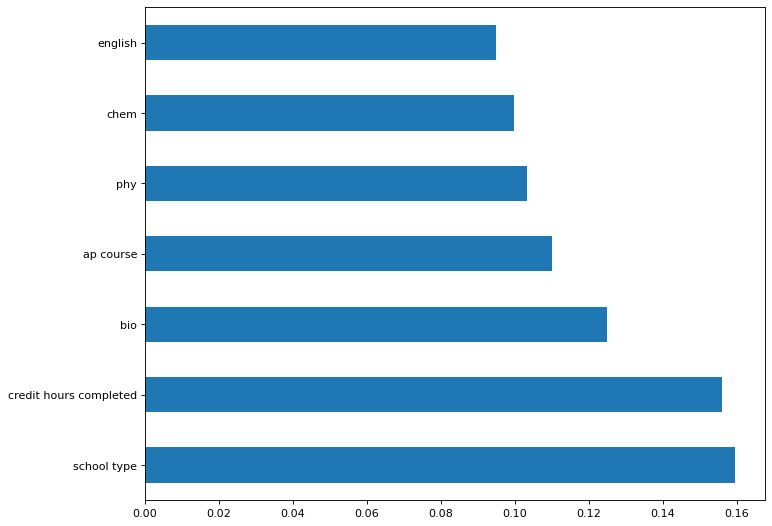

In [58]:
feature_cols = ['alevel math', 'olevel math', 'chem', 'phy', 'bio', 
                                                     'english', 'ap course', 'cs ig', 
                                                     'international student', 'transferred courses', 'cgpa',
                                                     'credit hours completed', 'school type']

plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')

feat_importances = pd.Series(rf.feature_importances_, index= feature_cols)

feat_importances.nlargest(7).plot(kind='barh')

## Correlation Matrix (NOT DONE)

Top 3 Correlations with label:
- Credit hours completed : Impact of increasing the completed credit hours is minimal but positive with specialization
- CGPA : Impact of an increasing gpa suggests that there may be some correlation where some gpa's translate to certain specializations
- Olevel math / Chemistry : Both indicate that a high value in these courses impact choice of specialization

Bottom 3 Correlations with label:
- Multicollinearity of numeric features 

In [59]:
corr_matrix = data.corr(min_periods=2)

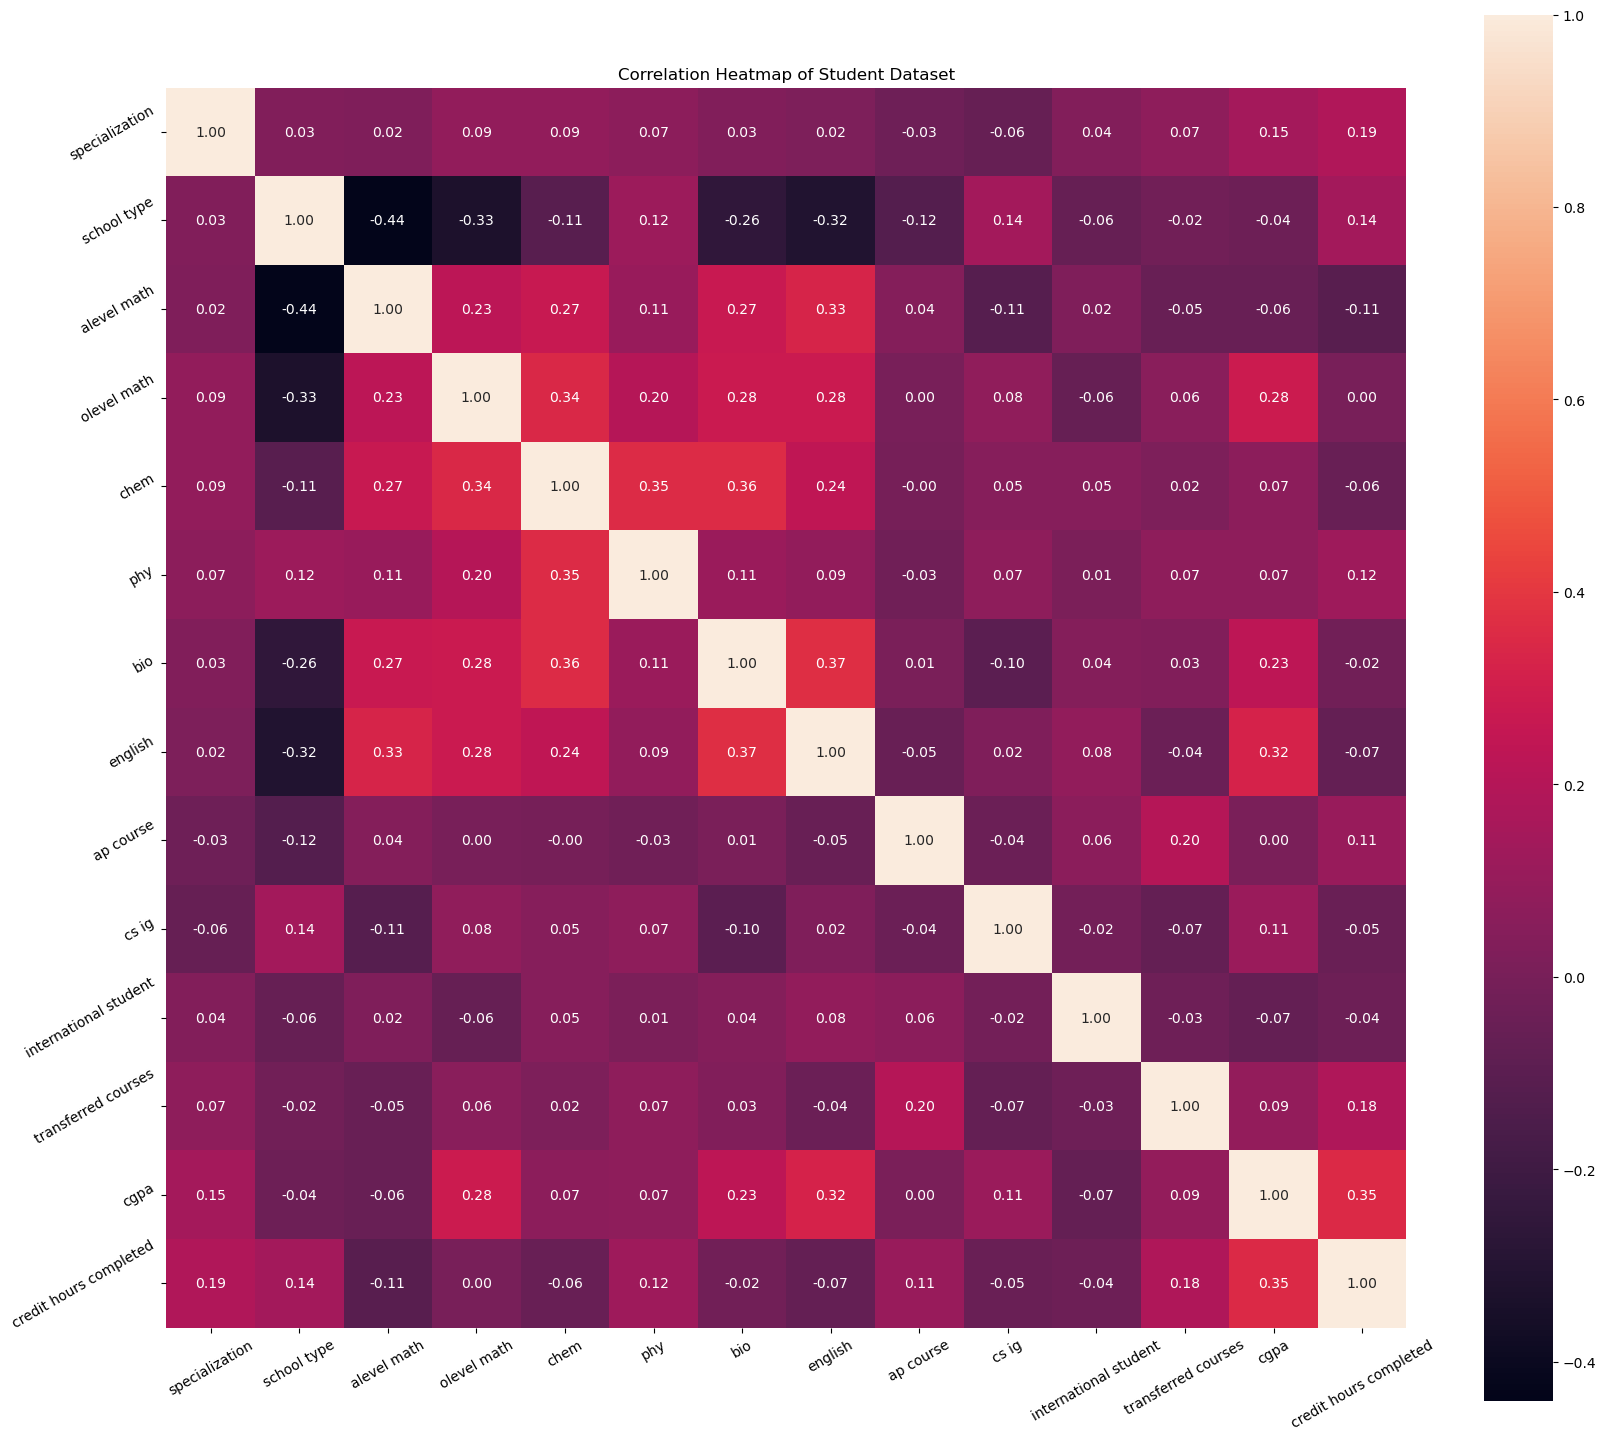

In [60]:
plt.figure(figsize=(20,18))
plt.title('Correlation Heatmap of Student Dataset')
a = sns.heatmap(corr_matrix, square=True, annot=True, fmt='.2f', linecolor='black', mask=False)
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show() 

## PCA

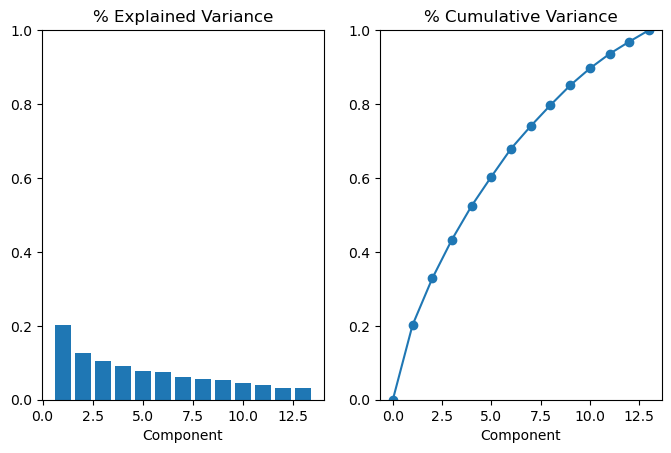

In [61]:
from sklearn.decomposition import PCA

#scaling
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

plot_variance(pca);

# Data Augmentation

In [62]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

X = RobustScaler().fit_transform(X)


In [63]:
oversample = RandomOverSampler()
X, y = oversample.fit_resample(X, y)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [65]:
# For GNB Only
X_gnb = data.iloc[:, 1:8]
y_gnb = data.iloc[:, 0]

X_gnb = RobustScaler().fit_transform(X_gnb)


In [66]:
oversample = RandomOverSampler()
X_gnb, y_gnb = oversample.fit_resample(X_gnb, y_gnb)

In [67]:
X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(X_gnb, y_gnb, test_size=0.2, stratify=y)

# Model & Knowledge Fusion

Models: RF, DT, Gaussian NB, Voting Classifier (RF, DT, GNB), Voting Classifier (RF, BNB, GNB)

# Hyperparameter Optimization

In [68]:
rf = RandomForestClassifier(n_estimators=125, criterion='gini', max_depth=15, ccp_alpha=0.001)

dt = DecisionTreeClassifier(criterion='entropy', max_depth=None, ccp_alpha=0.05)

gnb = GaussianNB()

bnb = BernoulliNB()

vc1 = VotingClassifier([('Random Forest', rf), ('Bernoulli NB', bnb), ('Gaussian NB', gnb)], voting='soft', weights=(2,1,1))

vc2 = VotingClassifier([('Random Forest', rf), ('Decision Tree', dt), ('Voting Classifier 1', vc1)], voting='soft', weights=(2,1,1))

In [96]:
# rf optimization
estimators_rf = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200]
criterion_rf = ['gini', 'entropy']
md_rf = [None, 2, 4, 6, 8, 10, 15, 20, 25, 30, 40, 50]
ccp_rf = [0.1, 0.05, 0.01, 0.005, 0.001]
param_grid_rf = dict(n_estimators=estimators_rf, criterion=criterion_rf, max_depth=md_rf, ccp_alpha=ccp_rf)

gs_rf = GridSearchCV(rf, param_grid_rf, cv=10)
rf_results = gs_rf.fit(X_train, y_train)

C:\Users\Islam.Anwar\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


In [97]:
print("Best: {0}, using {1}".format(rf_results.cv_results_['mean_test_score'], rf_results.best_params_))
rf_df = pd.DataFrame(rf_results.cv_results_)

Best: [0.20833333 0.20833333 0.20833333 ... 0.3625     0.3625     0.37083333], using {'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 15, 'n_estimators': 125}


In [98]:
# dt optimization
criterion_dt = ['gini', 'entropy']
md_dt = [None, 2, 4, 6, 8, 10, 15, 20, 25, 30, 40, 50]
ccp_dt = [0.1, 0.05, 0.01, 0.005, 0.001]
param_grid_dt = dict(criterion=criterion_dt, max_depth=md_dt, ccp_alpha=ccp_dt)

gs_dt = GridSearchCV(dt, param_grid_dt, cv=10)
dt_results = gs_dt.fit(X_train, y_train)

C:\Users\Islam.Anwar\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


In [99]:
print("Best: {0}, using {1}".format(dt_results.cv_results_['mean_test_score'], dt_results.best_params_))
dt_df = pd.DataFrame(dt_results.cv_results_)

Best: [0.20833333 0.20833333 0.20833333 0.20833333 0.20833333 0.20833333
 0.20833333 0.20833333 0.20833333 0.20833333 0.20833333 0.20833333
 0.25833333 0.25416667 0.25833333 0.25833333 0.25833333 0.25833333
 0.25833333 0.25833333 0.25833333 0.25833333 0.25833333 0.25833333
 0.20833333 0.20833333 0.20833333 0.20833333 0.20833333 0.20833333
 0.20833333 0.20833333 0.20833333 0.20833333 0.20833333 0.20833333
 0.325      0.2875     0.325      0.325      0.325      0.325
 0.325      0.325      0.325      0.325      0.325      0.325
 0.30416667 0.28333333 0.325      0.30833333 0.3        0.30833333
 0.30416667 0.30416667 0.30416667 0.30833333 0.30833333 0.30833333
 0.27916667 0.2875     0.30833333 0.30416667 0.29583333 0.28333333
 0.29583333 0.26666667 0.26666667 0.30416667 0.30416667 0.28333333
 0.24583333 0.28333333 0.30833333 0.2875     0.27083333 0.2625
 0.26666667 0.25       0.25833333 0.2375     0.2625     0.26666667
 0.27916667 0.2875     0.3125     0.31666667 0.3        0.29583333
 0.

In [100]:
# voting classifier optimization
voting_vc = ['hard', 'soft']
weights_vc = [(1,1,1), (2,1,1), (1,2,1), (1,1,2)]

param_grid_vc = dict(voting=voting_vc, weights=weights_vc)

gs_vc = GridSearchCV(vc2, param_grid_vc, cv=10)
vc_results = gs_vc.fit(X_train, y_train)

C:\Users\Islam.Anwar\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


In [101]:
gs_vc.best_params_

{'voting': 'hard', 'weights': (2, 1, 1)}

In [69]:
rf.fit(X_train, y_train)
dt.fit(X_train, y_train)
gnb.fit(X_train_gnb, y_train_gnb)
vc1.fit(X_train, y_train)
vc2.fit(X_train, y_train)

VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(ccp_alpha=0.001,
                                                     max_depth=15,
                                                     n_estimators=125)),
                             ('Decision Tree',
                              DecisionTreeClassifier(ccp_alpha=0.05,
                                                     criterion='entropy')),
                             ('Voting Classifier 1',
                              VotingClassifier(estimators=[('Random Forest',
                                                            RandomForestClassifier(ccp_alpha=0.001,
                                                                                   max_depth=15,
                                                                                   n_estimators=125)),
                                                           ('Bernoulli NB',
                                                            BernoulliNB()),
                                                           ('Gaussian NB',
                                                            GaussianNB())],
                                               voting='soft',
                                               weights=(2, 1, 1)))],
                 voting='soft', weights=(2, 1, 1))

In [70]:
y_pred_rf = rf.predict(X_test)
y_pred_dt = dt.predict(X_test)
y_pred_gnb = gnb.predict(X_test_gnb)
y_pred_vc1 = vc1.predict(X_test)
y_pred_vc2 = vc2.predict(X_test)

In [71]:
print(classification_report(y_pred_rf, y_test))
print(classification_report(y_pred_dt, y_test))
print(classification_report(y_pred_gnb, y_test_gnb))
print(classification_report(y_pred_vc1, y_test))
print(classification_report(y_pred_vc2, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.62      0.42      0.50        19
           2       0.69      0.60      0.64        15
           3       0.43      1.00      0.60         6
           4       0.77      0.77      0.77        13
           5       1.00      1.00      1.00        14
           6       0.62      0.67      0.64        12
           7       0.69      0.64      0.67        14

    accuracy                           0.73       106
   macro avg       0.73      0.76      0.73       106
weighted avg       0.74      0.73      0.72       106

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.77      0.29      0.43        34
           2       0.08      0.25      0.12         4
           3       0.14      0.67      0.24         3
           4       0.38      0.25      0.30        20
           5       1.00 

# Local Model Interpretations

## Decision Paths

In [72]:
n_nodes = dt.tree_.node_count
children_left = dt.tree_.children_left
children_right = dt.tree_.children_right
feature = dt.tree_.feature
threshold = dt.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 19 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 1] <= 1.2999999523162842 else to node 16.
	node=1 is a split node: go to node 2 if X[:, 4] <= -1.412500023841858 else to node 9.
		node=2 is a split node: go to node 3 if X[:, 12] <= -0.375 else to node 8.
			node=3 is a split node: go to node 4 if X[:, 11] <= -0.6118547022342682 else to node 5.
				node=4 is a leaf node.
				node=5 is a split node: go to node 6 if X[:, 6] <= 0.6304347813129425 else to node 7.
					node=6 is a leaf node.
					node=7 is a leaf node.
			node=8 is a leaf node.
		node=9 is a split node: go to node 10 if X[:, 11] <= -0.15296366810798645 else to node 13.
			node=10 is a split node: go to node 11 if X[:, 6] <= -0.2391304299235344 else to node 12.
				node=11 is a leaf node.
				node=12 is a leaf node.
			node=13 is a split node: go to node 14 if X[:, 2] <= -0.1111111156642437 else to node 15.
				node=14 is a leaf node.
				node=15 is a l

Decision making process begins as such:
- Olevel math
- Bio or Phy
- School type or Credit hours completed

Trickle down effect into rest of unimportant features

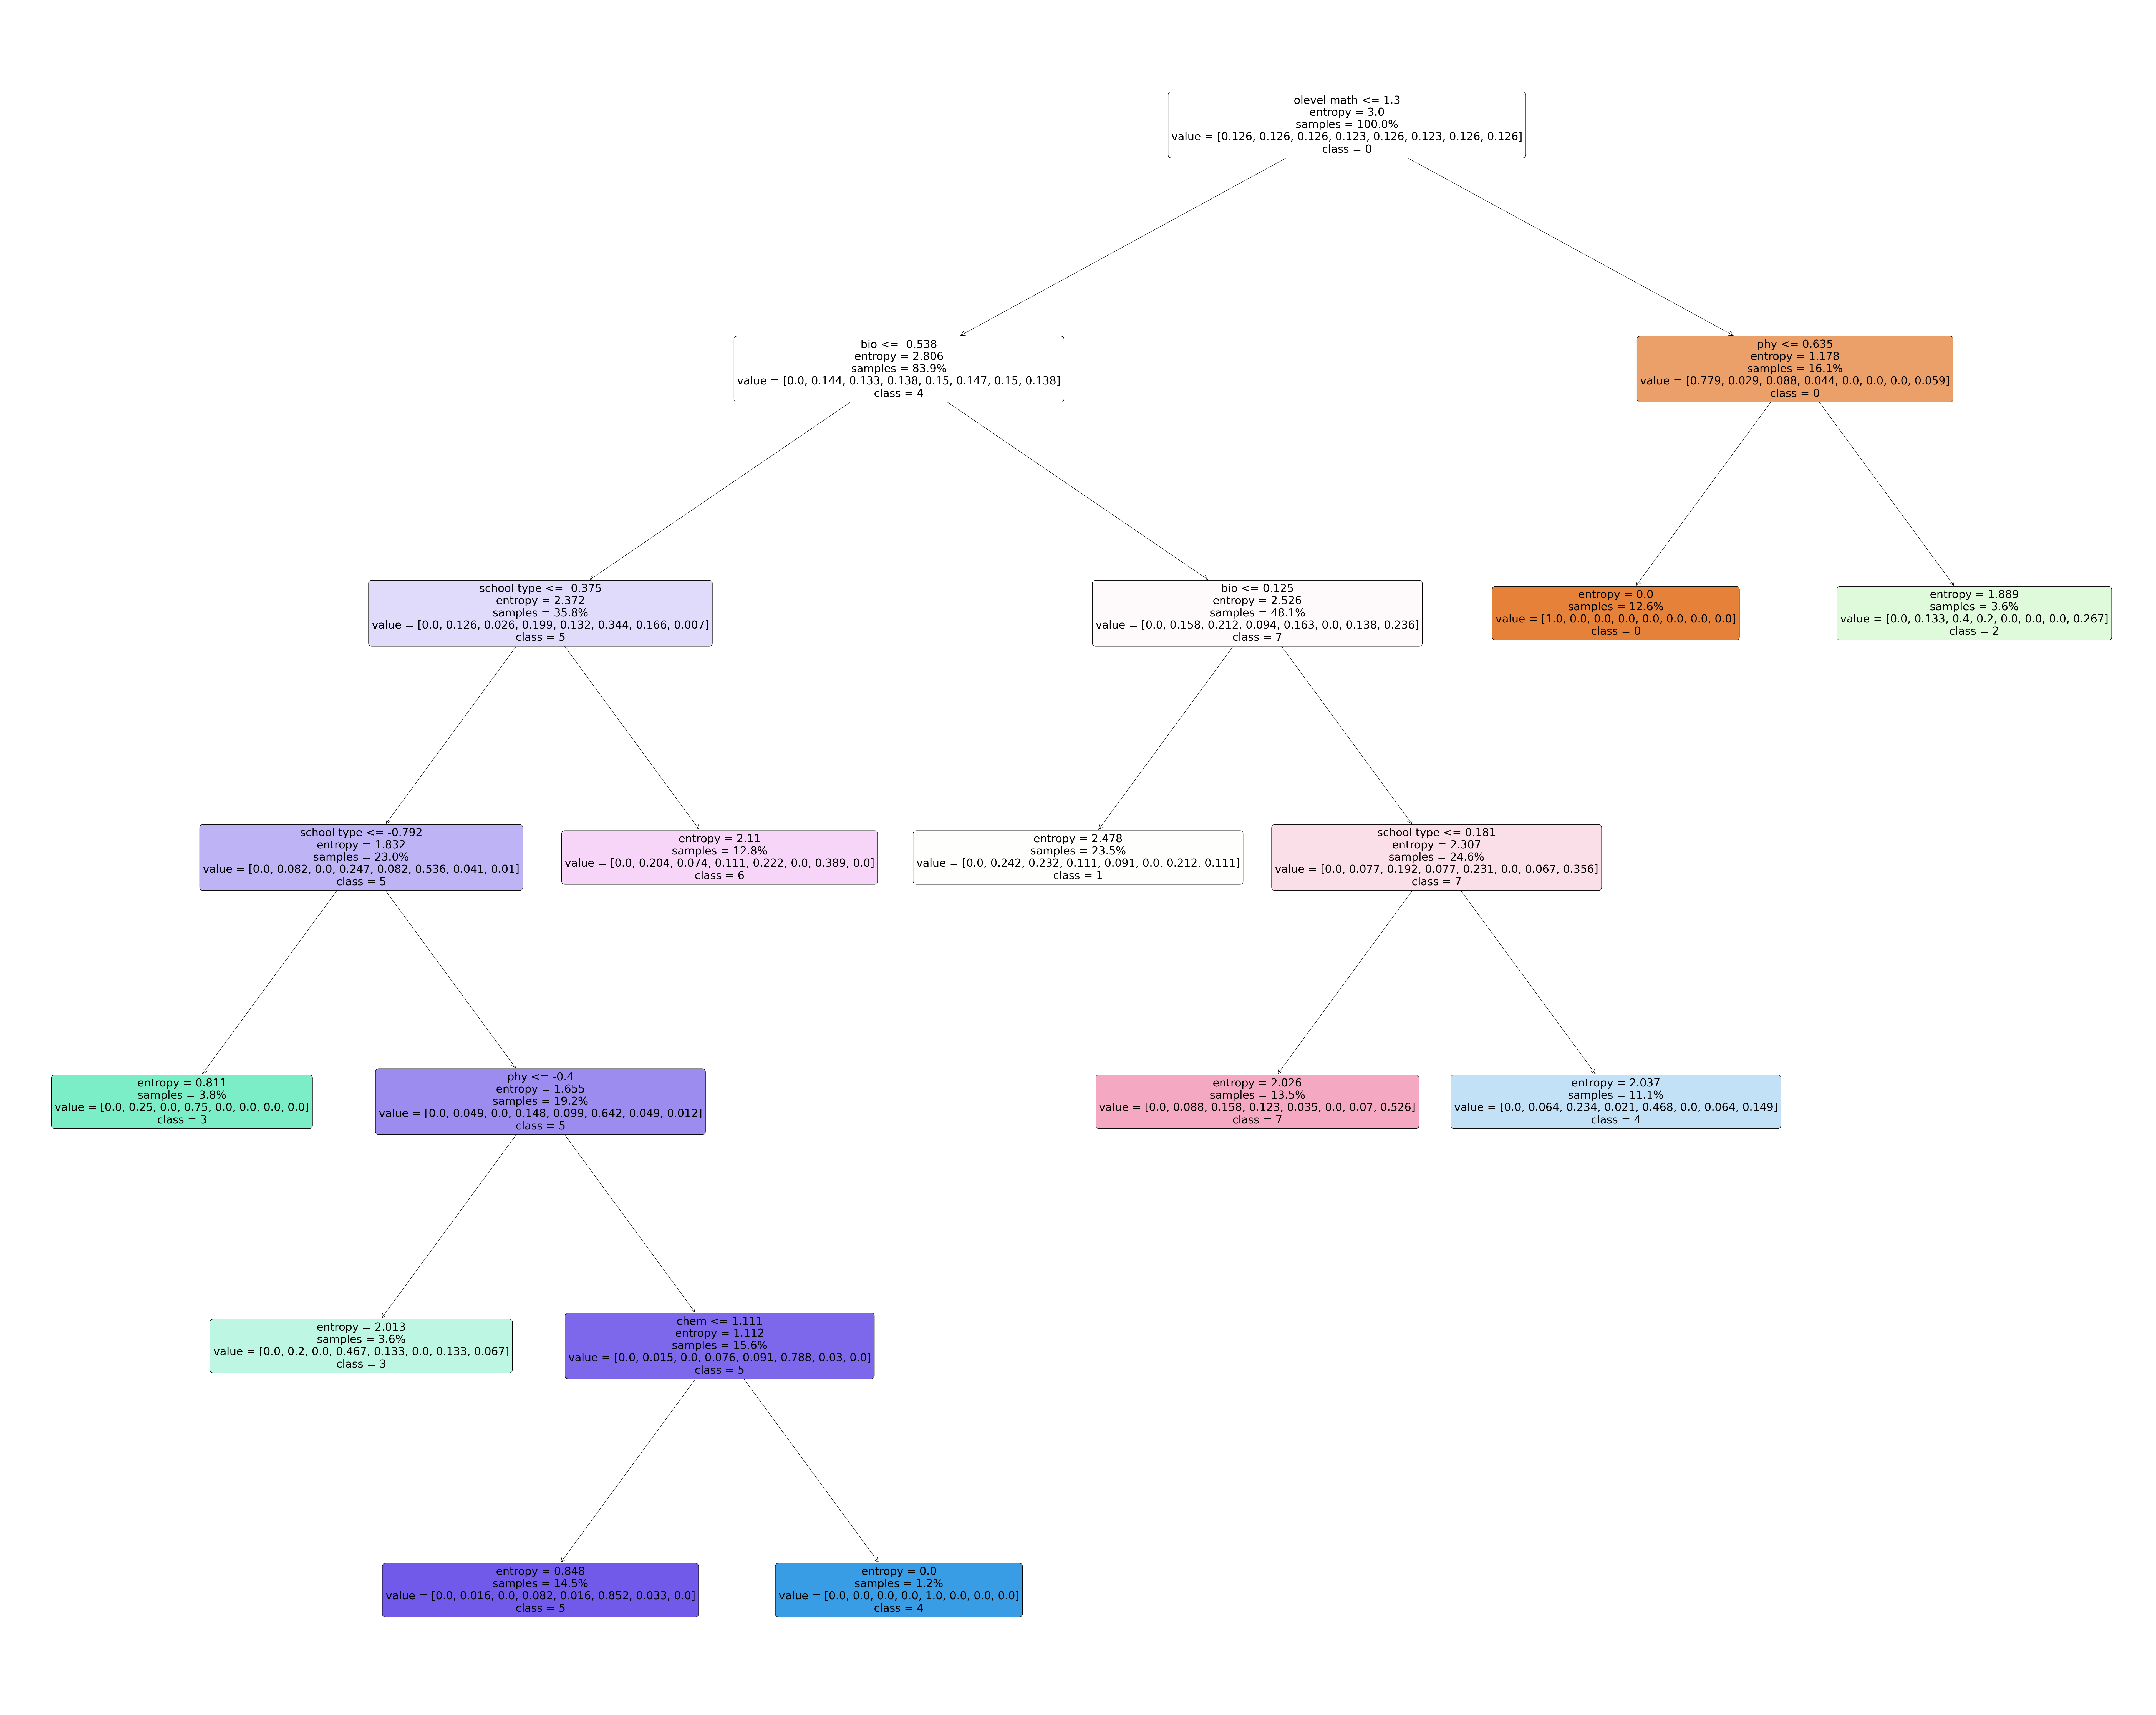

In [72]:
from sklearn.tree import plot_tree
plt.figure(figsize=(100, 80))
plot_tree(dt,
          feature_names=feature_cols,
          class_names=['0','1', '2', '3', '4', '5','6','7'],
          rounded=True, # Rounded node edges
          filled=True, # Adds color accoding to class
          proportion=True)
plt.show()

In [74]:
node_indicator = dt.decision_path(X_test)
leaf_id = dt.apply(X_test)

sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]


print("Rules used to predict sample {id}:\n".format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=feature[node_id],
            value=X_test[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )

Rules used to predict sample 0:

decision node 0 : (X_test[0, 1] = 1.3333333333333333) > 1.2999999523162842)
decision node 16 : (X_test[0, 3] = 1.1764705882352942) > 0.6352941244840622)


## Feature Importance

<Axes: >

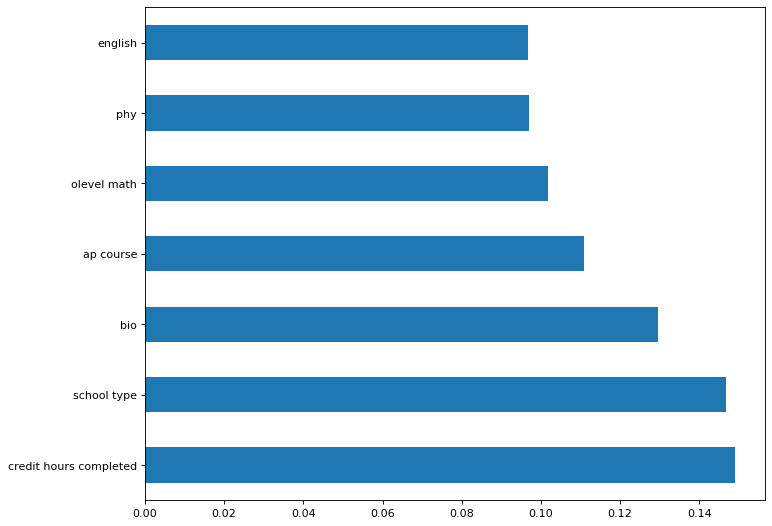

In [73]:
feature_cols = ['alevel math', 'olevel math', 'chem', 'phy', 'bio', 
                                                     'english', 'ap course', 'cs ig',
                                                     'international student', 'transferred courses', 'cgpa',
                                                     'credit hours completed', 'school type']

plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')

feat_importances = pd.Series(rf.feature_importances_, index= feature_cols)

feat_importances.nlargest(7).plot(kind='barh')

## Shapley Values

In [76]:
import shap
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)

# Calculate Shap values
shap_values = explainer.shap_values(X_train)

In [77]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_train, ['alevel math', 'olevel math', 'chem', 'phy', 'bio', 
                                                     'english', 'ap course', 'cs ig',
                                                     'international student', 'transferred courses', 'cgpa',
                                                     'credit hours completed', 'school type'])

## Partial Dependence Plots of Shap Values

In [78]:
from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_interact_plot, pdp_plot

In [79]:
X_test = pd.DataFrame(X_test, columns=['alevel math', 'olevel math', 'chem', 'phy', 'bio', 
                                                     'english', 'ap course', 'cs ig', 
                                                     'international student', 'transferred courses', 'cgpa',
                                                     'credit hours completed', 'school type'])

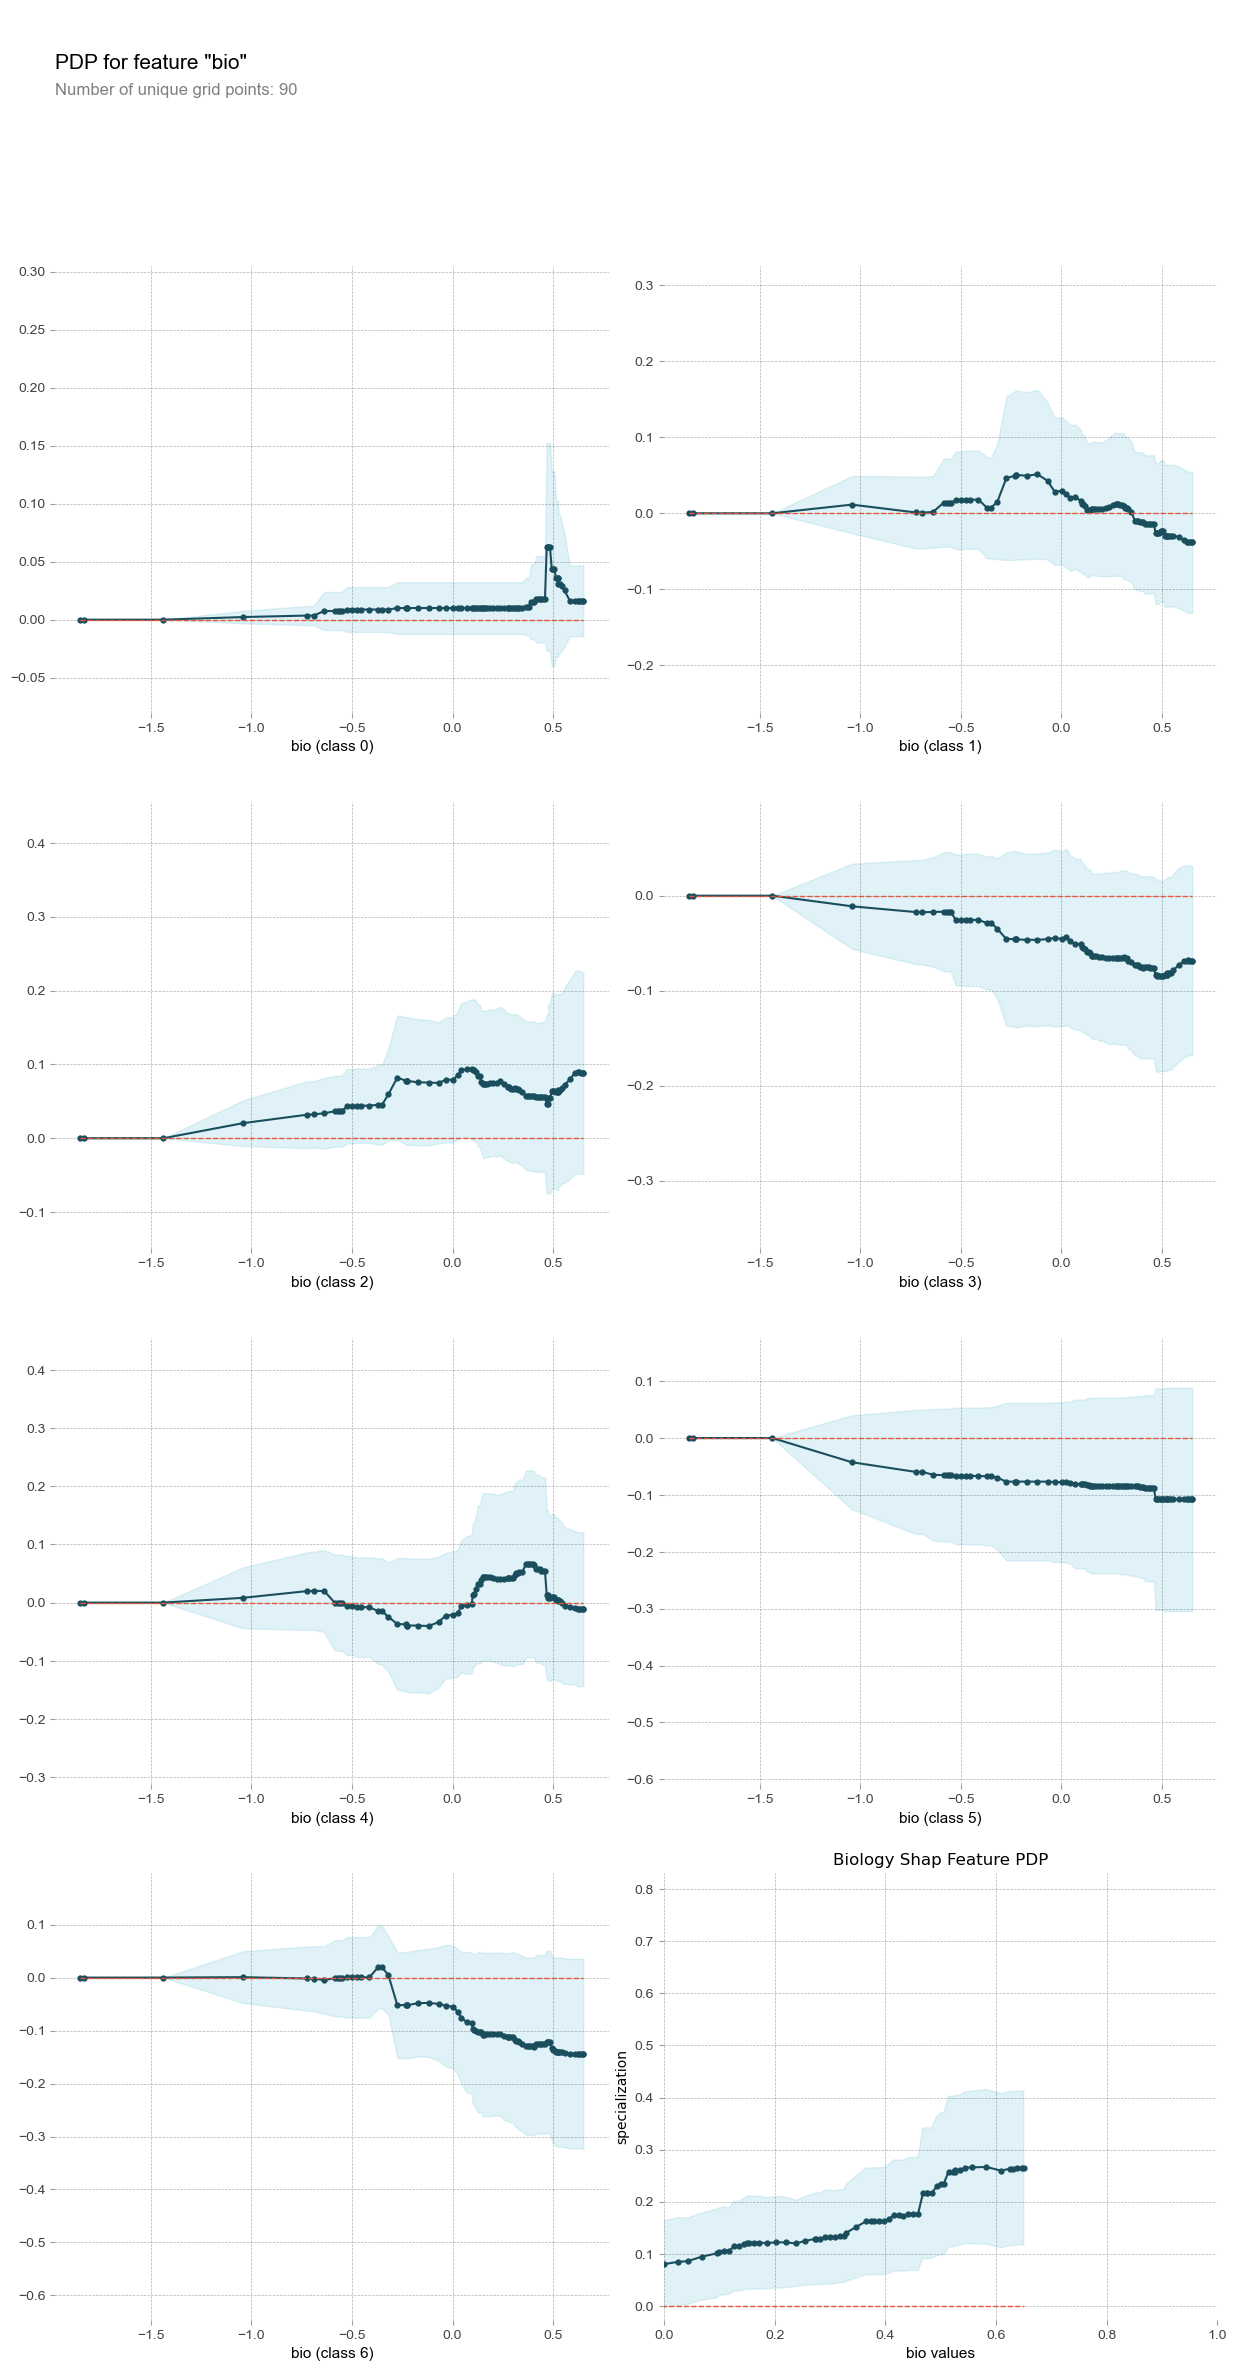

In [90]:
pdp('bio', X_test, rf, title='Biology Shap Feature PDP', ylabel='specialization', xlabel='bio values')

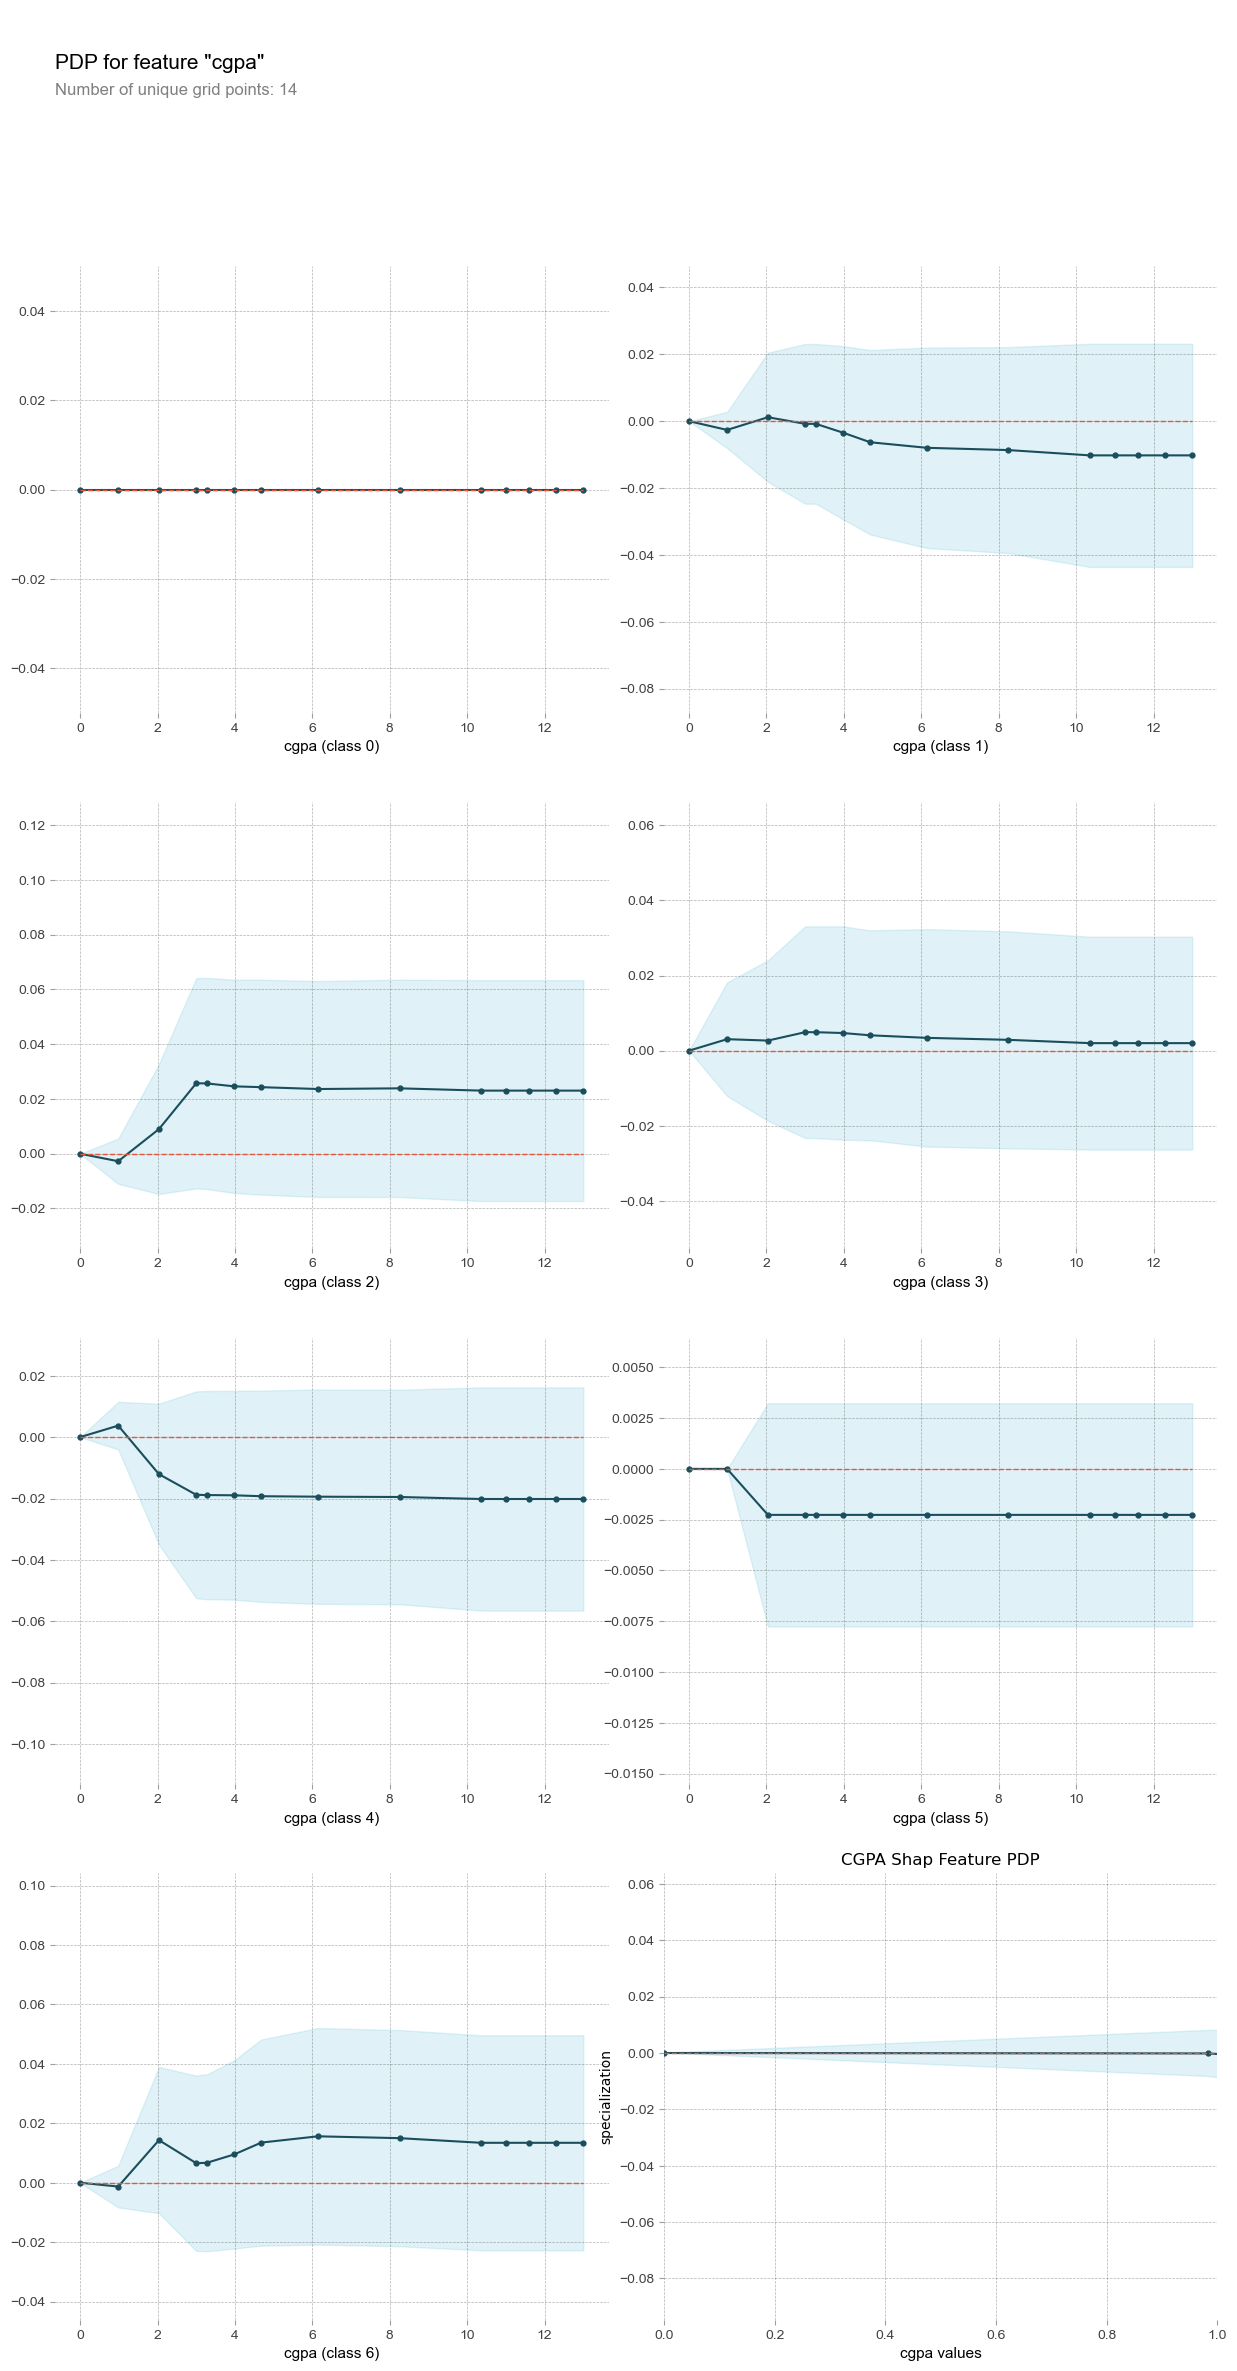

In [91]:
pdp('cgpa', X_test, rf, title='CGPA Shap Feature PDP', ylabel='specialization', xlabel='cgpa values')